In [2]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

%load_ext autoreload
%autoreload 2

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [ ]:
# Train/Test RNN
import h5py
import numpy as np
import pickle
from inputs import Data, load_separators, _build_bin_output, build_IO_from_var, build_DTA_from_var
from RNN import modelRNN
from features import get_init_end_dates, get_group_name

dateTest = ([                                                       '2018.03.09',
                '2018.03.12','2018.03.13','2018.03.14','2018.03.15','2018.03.16',
                '2018.03.19','2018.03.20','2018.03.21','2018.03.22','2018.03.23',
                '2018.03.26','2018.03.27','2018.03.28','2018.03.29','2018.03.30',
                '2018.04.02','2018.04.03','2018.04.04','2018.04.05','2018.04.06',
                '2018.04.09','2018.04.10','2018.04.11','2018.04.12','2018.04.13',
                '2018.04.16','2018.04.17','2018.04.18','2018.04.19','2018.04.20',
                '2018.04.23','2018.04.24','2018.04.25','2018.04.26','2018.04.27',
                '2018.04.30','2018.05.01','2018.05.02','2018.05.03','2018.05.04',
                '2018.05.07','2018.05.08','2018.05.09','2018.05.10','2018.05.11',
                '2018.05.14','2018.05.15','2018.05.16','2018.05.17','2018.05.18',
                '2018.05.21','2018.05.22','2018.05.23','2018.05.24','2018.05.25',
                '2018.05.28','2018.05.29','2018.05.30','2018.05.31','2018.06.01',
                '2018.06.04','2018.06.05','2018.06.06','2018.06.07','2018.06.08',
                '2018.06.11','2018.06.12','2018.06.13','2018.06.14','2018.06.15',
                '2018.06.18','2018.06.19','2018.06.20','2018.06.21','2018.06.22',
                '2018.06.25','2018.06.26','2018.06.27','2018.06.28','2018.06.29',
                '2018.07.02','2018.07.03','2018.07.04','2018.07.05','2018.07.06',
                '2018.07.09','2018.07.10','2018.07.11','2018.07.12','2018.07.13',
                '2018.07.30','2018.07.31','2018.08.01','2018.08.02','2018.08.03',
                '2018.08.06','2018.08.07','2018.08.08','2018.08.09','2018.08.10']+
               ['2018.08.13','2018.08.14','2018.08.15','2018.08.16','2018.08.17',
                '2018.08.20','2018.08.21','2018.08.22','2018.08.23','2018.08.24',
                '2018.08.27','2018.08.28','2018.08.29','2018.08.30','2018.08.31',
                '2018.09.03','2018.09.04','2018.09.05','2018.09.06','2018.09.07',
                '2018.09.10','2018.09.11','2018.09.12','2018.09.13','2018.09.14',
                '2018.09.17','2018.09.18','2018.09.19','2018.09.20','2018.09.21',
                '2018.09.24','2018.09.25','2018.09.26','2018.09.27']+['2018.09.28',
                '2018.10.01','2018.10.02','2018.10.03','2018.10.04','2018.10.05',
                '2018.10.08','2018.10.09','2018.10.10','2018.10.11','2018.10.12',
                '2018.10.15','2018.10.16','2018.10.17','2018.10.18','2018.10.19',
                '2018.10.22','2018.10.23','2018.10.24','2018.10.25','2018.10.26',
                '2018.10.29','2018.10.30','2018.10.31','2018.11.01','2018.11.02',
                '2018.11.05','2018.11.06','2018.11.07','2018.11.08','2018.11.09'])

data=Data(movingWindow=100,
          nEventsPerStat=1000,
          lB=1300, 
          dateTest=dateTest,
          assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32],
          channels=[0],
          max_var=10,
          feature_keys_manual=[],
          feature_keys_tsfresh=[],#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)],
          var_feat_keys=[i for i in range(68,93)])

model=modelRNN(data,
               size_hidden_layer=100,
               L=3,
               size_output_layer=5,
               keep_prob_dropout=1,
               miniBatchSize=32,
               outputGain=.6,
               commonY=3,
               lR0=0.0001,
               num_epochs=20)

tOt = 'tr' # tr->train te->test
if tOt == 'tr':
    calculate_roi = False
else:
    calculate_roi = True
if_build_IO = False
from_stats_file = False

IDweights = '000400'
IDresults = '100400'
IO_results_name = IDresults
hdf5_directory = 'D:/SDC/py/HDF5/'
feats_var_directory = hdf5_directory+'feats_var/'
IO_directory = '../RNN/IO/'
if tOt=='tr':
    filename_IO = IO_directory+'IO_'+IDweights+'.hdf5'
else:
    filename_IO = IO_directory+'IO_'+IO_results_name+'.hdf5'
separators_directory = hdf5_directory+'separators/'

# if IO structures have to be built 
if if_build_IO:
    # init dictionary containing IO structures
    IO = {}
    # open IO file for writting
    f_IO = h5py.File(filename_IO,'w')
    # init IO data sets
    X = f_IO.create_dataset('X',
                            (0, model.seq_len, model.nFeatures), 
                            maxshape=(None,model.seq_len, model.nFeatures), 
                            dtype=float)
    Y = f_IO.create_dataset('Y',
                            (0,model.seq_len,model.commonY+model.size_output_layer),
                            maxshape=(None,model.seq_len,model.commonY+
                            model.size_output_layer),
                            dtype=float)
    if calculate_roi:
        D = f_IO.create_dataset('D', (0,2),
                                    maxshape=(None,2),dtype='S19')
        B = f_IO.create_dataset('B', (0,2),
                                    maxshape=(None,2),dtype=float)
        A = f_IO.create_dataset('A', (0,2),
                                    maxshape=(None,2),dtype=float)
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    # attributes to track asset-IO belonging
    ass_IO_ass = np.zeros((len(data.assets))).astype(int)
    # structure that tracks the number of samples per level
    totalSampsPerLevel = np.zeros((model.size_output_layer))
    # save IO structures in dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = 0
    
for ass_idx, ass in enumerate(data.assets):
    thisAsset = data.AllAssets[str(ass)]
    print(str(ass)+" "+thisAsset)
    #thisAsset = 'EURUSD'
    # load separators
    separators = load_separators(data, 
                                 thisAsset, 
                                 separators_directory, 
                                 tOt='tr', 
                                 from_txt=1)
    aloc = 2**20
    # index asset
    #ass_idx = 0

    filename_features = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_features = h5py.File(filename_features,'r')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'r')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'r')
    filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                    str(data.nEventsPerStat)+'.p')
    # init or load total stats
    if not from_stats_file:
        stats = {}
        # load stats in
        stats["means_in"] = file_features[thisAsset].attrs.get("means_in")
        stats["stds_in"] = file_features[thisAsset].attrs.get("stds_in")
        stats["m_in"] = file_features[thisAsset].attrs.get("m_in")
        # load stats out
        stats["means_out"] = file_returns[thisAsset].attrs.get("means_out")
        stats["stds_out"] = file_returns[thisAsset].attrs.get("stds_out")
        stats["m_out"] = file_returns[thisAsset].attrs.get("m_out")
    elif from_stats_file:
        stats = pickle.load( open( filename_stats, "rb" ))
    print(stats)

    nExS = data.nEventsPerStat
    mW = data.movingWindow
    if if_build_IO:
        for s in range(0,len(separators)-1,2):#
            print("\ts {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                  ". From "+separators.DateTime.iloc[s]+" to "+
                  separators.DateTime.iloc[s+1])

            # number of events within this separator chunk
            nE = separators.index[s+1]-separators.index[s]+1
            # get first day after separator
            day_s = separators.DateTime.iloc[s][0:10]
            # check if number of events is not enough to build two features and one return
            if nE-nExS>=2*nExS:
                if (tOt == 'tr' and (day_s not in data.dateTest and day_s<=data.dateTest[-1])) or \
                    (tOt == 'te' and (day_s in data.dateTest and day_s<=data.dateTest[-1])):
                    # init and end dates
                    init_date, end_date = get_init_end_dates(separators, s)
                    #print("init_date")
                    #print(init_date)
                    #print("end_date")
                    #print(end_date)
                    # get group name
                    group_name = get_group_name(thisAsset, init_date, end_date)
                    #print("group_name")
                    #print(group_name)
                    # load features
                    if group_name in file_features:
                        features = file_features[group_name]["features"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print("features")
                    #print(features)
                    # load returns
                    if group_name in file_returns:
                        returns = file_returns[group_name]["returns"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print(returns)
                    # load Symbols if calculate_roi is true
                    #TODO: Implement Symbol loading for test
                    if calculate_roi:
                        DT = file_symbols[group_name]["DT"]
                        B = file_symbols[group_name]["B"]
                        A = file_symbols[group_name]["A"]
                        # build dict w. symbols
                        symbols = {'DT':DT,
                                  'B':B,
                                  'A':A}
                    else:
                        symbols = {}
                    # build IO
                    IO, totalSampsPerLevel = build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, 
                                                                        features, returns, symbols, calculate_roi)
                    print(totalSampsPerLevel)
                else:
                    print("\tNot in the set. Skipped.")

            else:
                print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(
                    int(s/2),int(len(separators)/2-1)))
        # end of for s in range(0,len(separators)-1,2):
    if if_build_IO:
        ass_IO_ass[ass_idx] = IO['pointer']
        #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
        #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of for ass_idx, ass in enumerate(data.assets):
if if_build_IO:
    print("Samples to RNN: "+str(max(ass_IO_ass))+".\nPercent per level:"+
            str(totalSampsPerLevel/max(ass_IO_ass)))
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    
    
    if calculate_roi:
        print("Building DTA...")
        DTA = build_DTA_from_var(data, IO['D'], IO['B'], IO['A'], ass_IO_ass)
        pickle.dump( DTA, open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "wb" ))
        f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
        
    f_IO.close()
else:
    if calculate_roi:
        DTA = pickle.load( open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "rb" ))
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = max(ass_IO_ass)
print("DONE")

In [8]:
m_t

733966

In [ ]:
# Train
import tensorflow as tf
# reset graph
alloc = 2**20
tf.reset_default_graph()
# start session
with tf.Session() as sess:    
    model.train(sess, int(np.ceil(m_t/aloc)), ID=IDweights, IDIO=IDweights, 
                data_format='hdf5', filename_IO=filename_IO, aloc=alloc)

In [ ]:
# Test
import tensorflow as tf

alloc = 200000
save_journal = False
startFrom = -1
endAt = -1
# reset graph
tf.reset_default_graph()
# start session
with tf.Session() as sess:
    # run test RNN
    print("IDresults: "+IDresults)
    # TEMP: GRE calculation not implemented in test2 yet. Use old test
    if save_journal:
        model.test(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt)
    else:
        model.test2(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt, from_var=True)
print("DONE")

In [1]:
# Function Build IO from var
def build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, features, returns, symbols, calculate_roi):
    # total number of possible channels
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nChannels = int(nExS/mW)
    # sequence length
    seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
    # samples allocation per batch
    aloc = 2**20
    # extract means and stats
    means_in = stats['means_in']
    stds_in = stats['stds_in']
    #m_in = stats['m_in']
    stds_out = stats['stds_out']
    #m_out = stats['m_out']
    #print("m_in")
    #print(m_in)
    #print("m_out")
    #print(m_out)
    # add dateTimes, bids and asks if are included in file
    if calculate_roi:
        dts = symbols['DT']
        bids = symbols['B']
        asks = symbols['A']

        D = IO['D']
        B = IO['B']
        A = IO['A']

    # extract IO structures
    X = IO['X']
    Y = IO['Y']
    #I = IO['I']
    pointer = IO['pointer']

    feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                         stds_in,-data.max_var),data.max_var)
    # get some scalars
    nSamps = feats_var_normed.shape[0]
    print("features.shape")
    print(features.shape)
    print("nSamps")
    print(nSamps)
    samp_remaining = nSamps-2*nChannels-seq_len+1
    print("samp_remaining")
    print(samp_remaining)
    print("returns.shape")
    print(returns.shape)
    chunks = int(np.ceil(samp_remaining/aloc))
    # init counter of samps processed
    offset = 0
    # loop over chunks
    for i in range(chunks):
        # this batch length
        batch = np.min([samp_remaining, aloc])
        # create support numpy vectors to speed up iterations
        v_support = feats_var_normed[offset:offset+batch+seq_len, :]
        # get init and end indexes for returns
        init_idx_rets = nChannels+offset+seq_len-1
        print("init_idx_rets")
        print(init_idx_rets)
        end_idx_rets = nChannels+offset+batch+seq_len-1#+2*seq_len-1
        print("end_idx_rets")
        print(end_idx_rets)
        r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
        print("r_support.shape")
        print(r_support.shape)
        assert(r_support.shape[0]==end_idx_rets-init_idx_rets)
        # we only take here the entry time index, and later at DTA building the 
        # exit time index is derived from the entry time and the number of events to
        # look ahead
        if calculate_roi:
            dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        # update remaining samps to proceed
        samp_remaining = samp_remaining-batch
        # init formatted input and output
        X_i = np.zeros((batch, seq_len, features.shape[1]))
        # real-valued output
        O_i = np.zeros((batch, seq_len, 1))    
        if calculate_roi:
            # last dimension is to incorporate in and out symbols
            D_i = np.chararray((batch, 2),itemsize=19)
            B_i = np.zeros((batch, 2))
            A_i = np.zeros((batch, 2))

        for nI in range(batch):
            # get input
            v_s_s = v_support[nI:nI+seq_len, :]
            X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
            # due to substraction of features for variation, output gets the 
            # feature one entry later
            O_i[nI,:,0] = r_support[nI]
            if calculate_roi:
                D_i[nI,:] = dt_support[nI,:]
                B_i[nI,:] = b_support[nI,:]
                A_i[nI,:] = a_support[nI,:]

        # normalize output
        O_i = O_i/stds_out[data.lookAheadIndex]
        # update counters
        offset = offset+batch
        # get decimal and binary outputs
        Y_i, y_dec = _build_bin_output(model, O_i, batch)
        # get samples per level
        for l in range(model.size_output_layer):
            totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
        # resize IO structures
        X.resize((pointer+batch, seq_len,features.shape[1]))
        Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
        # update IO structures
        X[pointer:pointer+batch,:,:] = X_i
        Y[pointer:pointer+batch,:,:] = Y_i
        if calculate_roi:
            # resize
            D.resize((pointer+batch, 2))
            B.resize((pointer+batch, 2))
            A.resize((pointer+batch, 2))
            # update
            D[pointer:pointer+batch,:] = D_i
            B[pointer:pointer+batch,:] = B_i
            A[pointer:pointer+batch,:] = A_i
    #        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
    #        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)

        # uodate pointer
        pointer += batch
    # end of for i in range(chunks):
    # update dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = pointer
    if calculate_roi:
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    
    return IO, totalSampsPerLevel
    

In [ ]:
# Snippet Build IO from var

# total number of possible channels
nChannels = int(nExS/mW)
# sequence length
seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
# samples allocation per batch
aloc = 2**20
# extract means and stats
means_in = stats['means_in']
stds_in = stats['stds_in']
m_in = stats['m_in']
stds_out = stats['stds_out']
m_out = stats['m_out']
#print("m_in")
#print(m_in)
#print("m_out")
#print(m_out)
# add dateTimes, bids and asks if are included in file
all_info = 0
if calculate_roi:
    all_info = 1
    dts = symbols['DT']
    bids = symbols['B']
    asks = symbols['A']
        
    D = IO['D']
    B = IO['B']
    A = IO['A']

# extract IO structures
X = IO['X']
Y = IO['Y']
#I = IO['I']
pointer = IO['pointer']

feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                     stds_in,-data.max_var),data.max_var)
# get some scalars
nSamps = feats_var_normed.shape[0]
samp_remaining = nSamps-nChannels-seq_len-1
print("samp_remaining")
print(samp_remaining)
chunks = int(np.ceil(samp_remaining/aloc))
# init counter of samps processed
offset = 0
# loop over chunks
for i in range(chunks):
    # this batch length
    batch = np.min([samp_remaining,aloc])
    print("batch")
    print(batch)
    # create support numpy vectors to speed up iterations
    v_support = feats_var_normed[offset:offset+batch+seq_len, :]
    # get init and end indexes for returns
    init_idx_rets = nChannels+offset+seq_len-1
    end_idx_rets = nChannels+offset+batch+2*seq_len-1
    r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
    print("returns.shape")
    print(returns.shape)
    print("nChannels+offset+2")
    print(nChannels+offset+2)
    print("nChannels+offset+batch+seq_len+2")
    print(nChannels+offset+batch+seq_len+2)
    print("r_support.shape")
    print(r_support.shape)
    print("nChannels+offset+batch+seq_len+2-(nChannels+offset+2)")
    print(nChannels+offset+batch+seq_len+2-(nChannels+offset+2))
    print("returns[-1,data.lookAheadIndex]")
    print(returns[-1,data.lookAheadIndex])
    print("r_support[-1]")
    print(r_support[-1])
    # we only take here the entry time index, and later at DTA building the 
    # exit time index is derived from the entry time and the number of events to
    # look ahead
    if calculate_roi:
        dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
    # update remaining samps to proceed
    samp_remaining = samp_remaining-batch
    # init formatted input and output
    X_i = np.zeros((batch, seq_len, features.shape[1]))
    # real-valued output
    O_i = np.zeros((batch, seq_len, 1))    
    if calculate_roi:
        # last dimension is to incorporate in and out symbols
        D_i = np.chararray((batch, 2),itemsize=19)
        B_i = np.zeros((batch, 2))
        A_i = np.zeros((batch, 2))
    
    for nI in range(batch):
        # get input
        v_s_s = v_support[nI:nI+seq_len, :]
        X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
        # due to substraction of features for variation, output gets the 
        # feature one entry later
        O_i[nI,:,0] = r_support[nI]
        if calculate_roi:
            D_i[nI,:] = dt_support[nI,:]
            B_i[nI,:] = b_support[nI,:]
            A_i[nI,:] = a_support[nI,:]
    
    # normalize output
    print("stds_out.shape")
    print(stds_out.shape)
    O_i = O_i/stds_out[data.lookAheadIndex]
    # update counters
    offset = offset+batch
    # get decimal and binary outputs
    Y_i, y_dec = _build_bin_output(model, O_i, batch)
    # get samples per level
    for l in range(model.size_output_layer):
        totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
    # resize IO structures
    X.resize((pointer+batch, seq_len,features.shape[1]))
    Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
    # update IO structures
    X[pointer:pointer+batch,:,:] = X_i
    Y[pointer:pointer+batch,:,:] = Y_i
    if calculate_roi:
        # resize
        D.resize((pointer+batch, 2))
        B.resize((pointer+batch, 2))
        A.resize((pointer+batch, 2))
        # update
        D[pointer:pointer+batch,:] = D_i
        B[pointer:pointer+batch,:] = B_i
        A[pointer:pointer+batch,:] = A_i
#        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
#        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)
        
    # uodate pointer
    pointer += batch
# end of for i in range(chunks):
# update dictionary
IO['X'] = X
IO['Y'] = Y
IO['pointer'] = pointer
if calculate_roi:
    IO['D'] = D
    IO['B'] = B
    IO['A'] = A
print("totalSampsPerLevel")
print(totalSampsPerLevel)

if if_build_IO:
    ass_IO_ass[ass_idx] = IO['pointer']
    #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
    #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of assets loop?
if if_build_IO:
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    f_IO.close()
else:
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = IO['pointer']
print("m_t")
print(m_t)
print("IO['pointer']")
print(IO['pointer'])

In [5]:
f_IO.close()

In [6]:
O_i.shape

(42319, 3, 1)

In [19]:
# Test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from config import configuration
# define config structure
entries = {'config_name':'C0400',
          
          'movingWindow':100,
          'nEventsPerStat':1000,
          'lB':1300,
          'feature_keys_manual':[],
          'feature_keys_tsfresh':[],
           'var_feat_keys':[i for i in range(68,93)],
          
          'if_build_IO':False,
          'from_stats_file':False,
          'IDweights':'000400',
          'inverse_load':True,
          
          'IDresults':'100400',
          'startFrom':-1,
          'endAt':-1,
          'save_journal':False}

config = configuration(entries)

WARNING! Arguments not taken into consideration
Config file ../config/C0400.config exists. Loaded from disk


In [ ]:
build_and_test(config)

In [16]:
from config import modify_config

modify_config(config['config_name'],'if_build_IO',False)
config = retrieve_config(config['config_name'])

[autoreload of inputs failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_generic
    update(a, b)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


Config file ../config/C0400.config saved
Config file ../config/C0400.config loaded from disk


In [ ]:
build_and_train(config)

In [26]:
import pandas as pd
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
#positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
positions

,Asset,Di,Ti,Do,To,GROI,ROI,spread,ext
0,AUDCAD,2018.03.19,00:57:38,2018.03.19,01:36:09,0.0337,0.0079,0.0257,0
1,AUDCAD,2018.03.20,02:51:09,2018.03.20,03:11:27,0.0407,0.0179,0.0228,0
2,AUDCAD,2018.03.22,00:59:23,2018.03.22,01:30:28,0.0929,0.0679,0.0250,0
3,AUDCAD,2018.03.22,02:30:14,2018.03.22,02:42:32,-0.1387,-0.1636,0.0249,0
4,AUDCAD,2018.03.23,01:00:56,2018.03.23,01:13:22,-0.0392,-0.0643,0.0251,0
5,AUDCAD,2018.03.26,00:13:48,2018.03.26,01:01:16,0.0413,0.0111,0.0302,0
6,AUDCAD,2018.03.28,23:43:57,2018.03.29,01:00:00,0.0808,0.0262,0.0546,3
7,AUDCAD,2018.03.30,02:16:01,2018.03.30,02:26:22,0.0718,-0.0071,0.0789,0
8,AUDCAD,2018.03.30,23:53:50,2018.04.02,01:53:14,0.0505,0.0212,0.0293,1
9,AUDCAD,2018.04.03,00:14:29,2018.04.03,00:38:47,0.0253,-0.0162,0.0415,1


In [90]:
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
pos_under_2p = positions['spread']<0.01
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print(positions[pos_under_2p].shape[0])
print(per_under_2p)
print(tgsr)
print(gsr)
print(tsr)
print(sr)
print(positions[pos_under_2p]['ROI'].sum())
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])
print(positions['Asset'][pos_under_2p].unique())

34
1.9871420222092344
82.46639392168322
61.76470588235294
37.697253068381066
52.94117647058823
0.06059999999999997
25.48230000000001
['EURCAD' 'EURCHF' 'EURGBP' 'EURUSD' 'GBPUSD' 'USDCAD' 'USDCHF' 'USDJPY'
 'EURJPY' 'GBPJPY']


In [27]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0327INVO')
config['IDresults']='100327R20'
config['save_journal']=True
config['startFrom']=9
config['endAt']=9
resolution = 20
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]

test_RNN(config)

Config file ../../config/C0327INVO.config loaded from disk
1. AUDCAD
	s 0 of 21. From 2016.01.04 00:00:08 to 2016.10.13 15:41:59
	Not in the set. Skipped.
	s 1 of 21. From 2016.10.13 17:52:00 to 2016.12.23 23:59:59
	Not in the set. Skipped.
	s 2 of 21. From 2016.12.26 06:00:00 to 2016.12.30 23:58:30
	Not in the set. Skipped.
	s 3 of 21. From 2017.01.02 09:00:00 to 2017.01.26 23:59:59
	Not in the set. Skipped.
	s 4 of 21. From 2017.01.30 00:05:00 to 2017.09.05 23:59:59
	Not in the set. Skipped.
	s 5 of 21. From 2017.09.06 20:25:01 to 2017.11.10 09:38:15
	Not in the set. Skipped.
	s 6 of 21. From 2017.11.10 10:05:52 to 2017.11.24 23:58:59
	Not in the set. Skipped.
	s 7 of 21. From 2017.11.27 00:05:00 to 2017.12.08 23:58:59
	Not in the set. Skipped.
	s 8 of 21. From 2017.12.11 00:05:00 to 2017.12.12 04:13:07
	Not in the set. Skipped.
	s 9 of 21. From 2017.12.12 09:55:53 to 2017.12.22 23:58:59
	Not in the set. Skipped.
	s 10 of 21. From 2017.12.26 03:00:00 to 2017.12.29 23:58:42
	Not in th

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:36<00:00,  5.04s/it]


Getting results
Epoch 9, J_train = 6.471134484857639, J_test = 6.279867172241211


0it [00:00, ?it/s]
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5410604425240708
RD = 397005 NZ = 762211 NZA = 1473208 pNZ = 44.159% pNZA = 85.351% AD = 52.09% ADA = 26.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 138844/138844 [00:27<00:00, 5096.26it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.55
RD = 44280 NZ = 75030 NZA = 138845 pNZ = 4.347% pNZA = 8.044% AD = 59.02% ADA = 31.89% NO = 23717 GSP = 57.79% NSP = 43.53%
SI2 = -2364.35 SI = -2721.35 eGROI = 118.66% eROI = -406.34% eROI2 = -355.68% eROI3 = -592.85% mSpread = 0.0221%


100%|██████████████████████████████████████████████████████████████████████████| 32279/32279 [00:07<00:00, 4505.67it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11309 NZ = 16300 NZA = 32280 pNZ = 0.944% pNZA = 1.870% AD = 69.38% ADA = 35.03% NO = 6128 GSP = 60.82% NSP = 41.33%
SI2 = -492.40 SI = -837.40 eGROI = 70.72% eROI = -99.85% eROI2 = -51.84% eROI3 = -113.12% mSpread = 0.0278%


100%|██████████████████████████████████████████████████████████████████████████| 12091/12091 [00:03<00:00, 3976.70it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.65
RD = 4799 NZ = 6200 NZA = 12092 pNZ = 0.359% pNZA = 0.701% AD = 77.40% ADA = 39.69% NO = 3448 GSP = 67.55% NSP = 42.11%
SI2 = -85.40 SI = -444.40 eGROI = 63.77% eROI = -48.71% eROI2 = -5.19% eROI3 = -39.67% mSpread = 0.0326%


100%|████████████████████████████████████████████████████████████████████████████| 4360/4360 [00:01<00:00, 3505.74it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1988 NZ = 2337 NZA = 4361 pNZ = 0.135% pNZA = 0.253% AD = 85.07% ADA = 45.59% NO = 1931 GSP = 77.37% NSP = 48.01%
SI2 = 127.95 SI = -135.05 eGROI = 61.14% eROI = -7.70% eROI2 = 22.52% eROI3 = 3.21% mSpread = 0.0356%


100%|████████████████████████████████████████████████████████████████████████████| 1777/1777 [00:00<00:00, 3170.15it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.75
RD = 904 NZ = 1002 NZA = 1778 pNZ = 0.058% pNZA = 0.103% AD = 90.22% ADA = 50.84% NO = 1026 GSP = 82.55% NSP = 52.83%
SI2 = 135.70 SI = -22.30 eGROI = 42.61% eROI = 2.92% eROI2 = 22.09% eROI3 = 11.83% mSpread = 0.0387%


100%|██████████████████████████████████████████████████████████████████████████████| 521/521 [00:00<00:00, 2778.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 293 NZ = 309 NZA = 522 pNZ = 0.018% pNZA = 0.030% AD = 94.82% ADA = 56.13% NO = 398 GSP = 85.18% NSP = 55.78%
SI2 = 64.10 SI = 3.10 eGROI = 18.56% eROI = 2.24% eROI2 = 10.60% eROI3 = 6.62% mSpread = 0.0410%


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1234.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.85
RD = 13 NZ = 13 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.47% NO = 16 GSP = 93.75% NSP = 75.00%
SI2 = 3.20 SI = 3.20 eGROI = 0.87% eROI = 0.27% eROI2 = 0.55% eROI3 = 0.39% mSpread = 0.0374%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.5
RD = 294402 NZ = 561892 NZA = 1018972 pNZ = 32.554% pNZA = 59.035% AD = 52.39% ADA = 28.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 103499/103499 [00:24<00:00, 4268.23it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.55
RD = 35487 NZ = 59897 NZA = 103500 pNZ = 3.470% pNZA = 5.996% AD = 59.25% ADA = 34.29% NO = 20505 GSP = 57.83% NSP = 44.22%
SI2 = -1839.75 SI = -2210.75 eGROI = 109.92% eROI = -350.08% eROI2 = -300.18% eROI3 = -505.23% mSpread = 0.0224%


100%|██████████████████████████████████████████████████████████████████████████| 24207/24207 [00:05<00:00, 4093.21it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.6
RD = 9096 NZ = 13105 NZA = 24208 pNZ = 0.759% pNZA = 1.403% AD = 69.41% ADA = 37.57% NO = 5344 GSP = 61.40% NSP = 41.49%
SI2 = -355.20 SI = -722.20 eGROI = 63.77% eROI = -90.15% eROI2 = -43.11% eROI3 = -96.55% mSpread = 0.0288%


100%|████████████████████████████████████████████████████████████████████████████| 9118/9118 [00:02<00:00, 3804.02it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.65
RD = 3861 NZ = 4986 NZA = 9119 pNZ = 0.289% pNZA = 0.528% AD = 77.44% ADA = 42.34% NO = 2898 GSP = 68.32% NSP = 41.89%
SI2 = -48.90 SI = -379.90 eGROI = 56.82% eROI = -42.67% eROI2 = -1.14% eROI3 = -30.12% mSpread = 0.0343%


100%|████████████████████████████████████████████████████████████████████████████| 3154/3154 [00:00<00:00, 3374.90it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.7
RD = 1565 NZ = 1835 NZA = 3155 pNZ = 0.106% pNZA = 0.183% AD = 85.29% ADA = 49.60% NO = 1542 GSP = 78.02% NSP = 50.00%
SI2 = 144.90 SI = -77.10 eGROI = 52.78% eROI = -4.76% eROI2 = 21.94% eROI3 = 6.52% mSpread = 0.0373%


100%|████████████████████████████████████████████████████████████████████████████| 1315/1315 [00:00<00:00, 3005.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.75
RD = 742 NZ = 819 NZA = 1316 pNZ = 0.047% pNZA = 0.076% AD = 90.60% ADA = 56.38% NO = 805 GSP = 83.85% NSP = 56.65%
SI2 = 130.25 SI = 13.25 eGROI = 36.97% eROI = 5.22% eROI2 = 20.87% eROI3 = 12.82% mSpread = 0.0394%


100%|██████████████████████████████████████████████████████████████████████████████| 416/416 [00:00<00:00, 2453.62it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.8
RD = 253 NZ = 265 NZA = 417 pNZ = 0.015% pNZA = 0.024% AD = 95.47% ADA = 60.67% NO = 327 GSP = 86.54% NSP = 58.72%
SI2 = 63.15 SI = 12.15 eGROI = 16.89% eROI = 3.42% eROI2 = 10.35% eROI3 = 7.08% mSpread = 0.0412%


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1670.99it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.85
RD = 13 NZ = 13 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.25% NO = 16 GSP = 93.75% NSP = 81.25%
SI2 = 4.20 SI = 4.20 eGROI = 0.92% eROI = 0.32% eROI2 = 0.60% eROI3 = 0.44% mSpread = 0.0374%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121454 NZ = 227015 NZA = 373328 pNZ = 13.152% pNZA = 21.629% AD = 53.50% ADA = 32.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 68003/68003 [00:16<00:00, 4013.54it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.55
RD = 25000 NZ = 41940 NZA = 68004 pNZ = 2.430% pNZA = 3.940% AD = 59.61% ADA = 36.76% NO = 14524 GSP = 58.19% NSP = 45.31%
SI2 = -1109.20 SI = -1407.20 eGROI = 90.16% eROI = -240.52% eROI2 = -200.32% eROI3 = -345.56% mSpread = 0.0228%


100%|██████████████████████████████████████████████████████████████████████████| 16853/16853 [00:04<00:00, 4096.46it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6745 NZ = 9759 NZA = 16854 pNZ = 0.565% pNZA = 0.976% AD = 69.12% ADA = 40.02% NO = 4317 GSP = 62.15% NSP = 42.78%
SI2 = -221.35 SI = -527.35 eGROI = 60.77% eROI = -67.00% eROI2 = -25.57% eROI3 = -68.74% mSpread = 0.0296%


100%|████████████████████████████████████████████████████████████████████████████| 6480/6480 [00:02<00:00, 2297.50it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.65
RD = 2913 NZ = 3715 NZA = 6481 pNZ = 0.215% pNZA = 0.375% AD = 78.41% ADA = 44.95% NO = 2308 GSP = 69.76% NSP = 43.50%
SI2 = 28.60 SI = -265.40 eGROI = 53.49% eROI = -28.83% eROI2 = 7.33% eROI3 = -15.75% mSpread = 0.0357%


100%|████████████████████████████████████████████████████████████████████████████| 2196/2196 [00:00<00:00, 2349.92it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1164 NZ = 1348 NZA = 2197 pNZ = 0.078% pNZA = 0.127% AD = 86.35% ADA = 52.98% NO = 1192 GSP = 79.03% NSP = 51.59%
SI2 = 128.40 SI = -40.60 eGROI = 44.14% eROI = -2.23% eROI2 = 20.30% eROI3 = 8.38% mSpread = 0.0389%


100%|███████████████████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 992.58it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.75
RD = 546 NZ = 592 NZA = 886 pNZ = 0.034% pNZA = 0.051% AD = 92.23% ADA = 61.63% NO = 600 GSP = 85.17% NSP = 59.17%
SI2 = 113.00 SI = 25.00 eGROI = 29.93% eROI = 5.32% eROI2 = 17.93% eROI3 = 11.93% mSpread = 0.0410%


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 1242.37it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 200 NZ = 208 NZA = 312 pNZ = 0.012% pNZA = 0.018% AD = 96.15% ADA = 64.10% NO = 255 GSP = 87.06% NSP = 60.78%
SI2 = 53.75 SI = 14.75 eGROI = 14.60% eROI = 3.90% eROI2 = 9.50% eROI3 = 6.95% mSpread = 0.0420%


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2339.83it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.85
RD = 12 NZ = 12 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 80.00% NO = 15 GSP = 93.33% NSP = 80.00%
SI2 = 3.75 SI = 3.75 eGROI = 0.84% eROI = 0.27% eROI2 = 0.54% eROI3 = 0.39% mSpread = 0.0385%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 94644/94644 [00:25<00:00, 3751.72it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.5
RD = 34541 NZ = 62809 NZA = 94645 pNZ = 3.639% pNZA = 5.483% AD = 54.99% ADA = 36.50% NO = 10005 GSP = 58.00% NSP = 45.95%
SI2 = -727.75 SI = -905.75 eGROI = 87.72% eROI = -141.09% eROI2 = -112.38% eROI3 = -212.43% mSpread = 0.0229%


100%|██████████████████████████████████████████████████████████████████████████| 36122/36122 [00:08<00:00, 4473.65it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.55
RD = 14145 NZ = 23686 NZA = 36123 pNZ = 1.372% pNZA = 2.093% AD = 59.72% ADA = 39.16% NO = 8132 GSP = 59.17% NSP = 46.80%
SI2 = -501.60 SI = -666.60 eGROI = 56.30% eROI = -133.09% eROI2 = -106.34% eROI3 = -187.66% mSpread = 0.0233%


100%|██████████████████████████████████████████████████████████████████████████| 10318/10318 [00:02<00:00, 3999.07it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.6
RD = 4373 NZ = 6431 NZA = 10319 pNZ = 0.373% pNZA = 0.598% AD = 68.00% ADA = 42.38% NO = 3176 GSP = 62.78% NSP = 45.15%
SI2 = -111.80 SI = -312.80 eGROI = 49.21% eROI = -44.17% eROI2 = -14.31% eROI3 = -46.07% mSpread = 0.0294%


100%|████████████████████████████████████████████████████████████████████████████| 3848/3848 [00:01<00:00, 2967.92it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.65
RD = 1807 NZ = 2314 NZA = 3849 pNZ = 0.134% pNZA = 0.223% AD = 78.09% ADA = 46.95% NO = 1564 GSP = 70.65% NSP = 45.52%
SI2 = 45.80 SI = -148.20 eGROI = 40.82% eROI = -15.96% eROI2 = 9.54% eROI3 = -6.10% mSpread = 0.0363%


100%|████████████████████████████████████████████████████████████████████████████| 1343/1343 [00:00<00:00, 2489.08it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.7
RD = 750 NZ = 873 NZA = 1344 pNZ = 0.051% pNZA = 0.078% AD = 85.91% ADA = 55.80% NO = 798 GSP = 79.57% NSP = 53.38%
SI2 = 94.10 SI = -12.90 eGROI = 32.92% eROI = 0.55% eROI2 = 16.96% eROI3 = 8.98% mSpread = 0.0406%


100%|██████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 2403.92it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.75
RD = 371 NZ = 401 NZA = 574 pNZ = 0.023% pNZA = 0.033% AD = 92.52% ADA = 64.63% NO = 419 GSP = 85.44% NSP = 59.67%
SI2 = 83.55 SI = 19.55 eGROI = 22.73% eROI = 4.87% eROI2 = 14.35% eROI3 = 10.16% mSpread = 0.0426%


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 2250.55it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.8
RD = 137 NZ = 143 NZA = 203 pNZ = 0.008% pNZA = 0.012% AD = 95.80% ADA = 67.49% NO = 174 GSP = 86.21% NSP = 61.49%
SI2 = 39.30 SI = 11.30 eGROI = 10.64% eROI = 2.85% eROI2 = 7.16% eROI3 = 5.42% mSpread = 0.0448%


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.78it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.85
RD = 11 NZ = 11 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 78.57% NO = 14 GSP = 92.86% NSP = 78.57%
SI2 = 3.30 SI = 3.30 eGROI = 0.78% eROI = 0.25% eROI2 = 0.50% eROI3 = 0.36% mSpread = 0.0381%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 24836/24836 [00:05<00:00, 4708.21it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9883 NZ = 17716 NZA = 24837 pNZ = 1.026% pNZA = 1.439% AD = 55.79% ADA = 39.79% NO = 4320 GSP = 58.31% NSP = 47.64%
SI2 = -205.00 SI = -318.00 eGROI = 36.42% eROI = -64.49% eROI2 = -49.98% eROI3 = -93.18% mSpread = 0.0234%


100%|██████████████████████████████████████████████████████████████████████████| 15070/15070 [00:03<00:00, 4252.83it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.55
RD = 6279 NZ = 10706 NZA = 15071 pNZ = 0.620% pNZA = 0.873% AD = 58.65% ADA = 41.66% NO = 3934 GSP = 58.26% NSP = 47.03%
SI2 = -193.70 SI = -313.70 eGROI = 27.05% eROI = -65.63% eROI2 = -51.63% eROI3 = -90.97% mSpread = 0.0236%


100%|████████████████████████████████████████████████████████████████████████████| 5073/5073 [00:01<00:00, 3597.19it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2342 NZ = 3540 NZA = 5074 pNZ = 0.205% pNZA = 0.294% AD = 66.16% ADA = 46.16% NO = 1972 GSP = 63.39% NSP = 49.49%
SI2 = 6.40 SI = -108.60 eGROI = 37.98% eROI = -17.56% eROI2 = -1.46% eROI3 = -21.18% mSpread = 0.0282%


100%|████████████████████████████████████████████████████████████████████████████| 1589/1589 [00:00<00:00, 2829.71it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.65
RD = 844 NZ = 1095 NZA = 1590 pNZ = 0.063% pNZA = 0.092% AD = 77.08% ADA = 53.08% NO = 889 GSP = 71.99% NSP = 50.96%
SI2 = 69.05 SI = -35.95 eGROI = 27.99% eROI = -3.83% eROI2 = 10.21% eROI3 = 1.32% mSpread = 0.0358%


100%|██████████████████████████████████████████████████████████████████████████████| 638/638 [00:00<00:00, 2894.11it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 379 NZ = 439 NZA = 639 pNZ = 0.025% pNZA = 0.037% AD = 86.33% ADA = 59.31% NO = 462 GSP = 80.52% NSP = 58.01%
SI2 = 69.90 SI = 13.90 eGROI = 20.65% eROI = 1.62% eROI2 = 11.41% eROI3 = 6.79% mSpread = 0.0412%


100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 2405.03it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.75
RD = 224 NZ = 242 NZA = 344 pNZ = 0.014% pNZA = 0.020% AD = 92.56% ADA = 65.12% NO = 275 GSP = 86.55% NSP = 61.82%
SI2 = 63.75 SI = 18.75 eGROI = 16.39% eROI = 4.10% eROI2 = 10.89% eROI3 = 8.14% mSpread = 0.0447%


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2159.64it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 86 NZ = 87 NZA = 113 pNZ = 0.005% pNZA = 0.007% AD = 98.85% ADA = 76.11% NO = 104 GSP = 88.46% NSP = 69.23%
SI2 = 26.80 SI = 14.80 eGROI = 6.90% eROI = 1.86% eROI2 = 4.82% eROI3 = 3.78% mSpread = 0.0485%


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.49it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.85
RD = 7 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 87.50% NO = 8 GSP = 87.50% NSP = 87.50%
SI2 = 1.60 SI = 2.60 eGROI = 0.52% eROI = 0.21% eROI2 = 0.36% eROI3 = 0.28% mSpread = 0.0380%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 6895/6895 [00:01<00:00, 3875.25it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.5
RD = 2918 NZ = 5222 NZA = 6896 pNZ = 0.303% pNZA = 0.400% AD = 55.88% ADA = 42.31% NO = 1949 GSP = 57.88% NSP = 48.08%
SI2 = -75.95 SI = -134.95 eGROI = 16.04% eROI = -31.22% eROI2 = -22.94% eROI3 = -42.43% mSpread = 0.0242%


100%|████████████████████████████████████████████████████████████████████████████| 4878/4878 [00:01<00:00, 3575.35it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2115 NZ = 3693 NZA = 4879 pNZ = 0.214% pNZA = 0.283% AD = 57.27% ADA = 43.35% NO = 1734 GSP = 57.79% NSP = 47.00%
SI2 = -81.70 SI = -138.70 eGROI = 8.74% eROI = -34.09% eROI2 = -25.94% eROI3 = -43.28% mSpread = 0.0247%


100%|████████████████████████████████████████████████████████████████████████████| 2325/2325 [00:00<00:00, 3521.49it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.6
RD = 1093 NZ = 1736 NZA = 2326 pNZ = 0.101% pNZA = 0.135% AD = 62.96% ADA = 46.99% NO = 1030 GSP = 63.98% NSP = 51.75%
SI2 = 20.50 SI = -33.50 eGROI = 19.59% eROI = -8.97% eROI2 = -1.01% eROI3 = -11.31% mSpread = 0.0277%


100%|██████████████████████████████████████████████████████████████████████████████| 703/703 [00:00<00:00, 3078.06it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.65
RD = 399 NZ = 529 NZA = 704 pNZ = 0.031% pNZA = 0.041% AD = 75.43% ADA = 56.68% NO = 457 GSP = 72.87% NSP = 57.55%
SI2 = 46.65 SI = 11.65 eGROI = 16.61% eROI = 1.52% eROI2 = 7.47% eROI3 = 2.90% mSpread = 0.0330%


100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 2505.88it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.7
RD = 179 NZ = 208 NZA = 281 pNZ = 0.012% pNZA = 0.016% AD = 86.06% ADA = 63.70% NO = 230 GSP = 80.43% NSP = 61.30%
SI2 = 43.50 SI = 14.50 eGROI = 11.08% eROI = 1.69% eROI2 = 6.48% eROI3 = 4.18% mSpread = 0.0408%


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 2156.42it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.75
RD = 110 NZ = 119 NZA = 158 pNZ = 0.007% pNZA = 0.009% AD = 92.44% ADA = 69.62% NO = 141 GSP = 86.52% NSP = 60.99%
SI2 = 35.45 SI = 8.45 eGROI = 8.51% eROI = 1.78% eROI2 = 5.69% eROI3 = 4.28% mSpread = 0.0477%


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1187.43it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.8
RD = 37 NZ = 38 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 97.37% ADA = 80.43% NO = 45 GSP = 93.33% NSP = 68.89%
SI2 = 13.25 SI = 6.25 eGROI = 3.46% eROI = 1.23% eROI2 = 2.56% eROI3 = 2.11% mSpread = 0.0494%


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.85
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 4 GSP = 100.00% NSP = 100.00%
SI2 = 0.80 SI = 1.80 eGROI = 0.38% eROI = 0.17% eROI2 = 0.30% eROI3 = 0.26% mSpread = 0.0510%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1924/1924 [00:00<00:00, 3023.74it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 864 NZ = 1522 NZA = 1925 pNZ = 0.088% pNZA = 0.112% AD = 56.77% ADA = 44.88% NO = 898 GSP = 56.90% NSP = 48.44%
SI2 = -39.90 SI = -58.90 eGROI = 7.10% eROI = -15.13% eROI2 = -10.86% eROI3 = -19.84% mSpread = 0.0247%


100%|████████████████████████████████████████████████████████████████████████████| 1365/1365 [00:00<00:00, 2731.83it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.55
RD = 604 NZ = 1072 NZA = 1366 pNZ = 0.062% pNZA = 0.079% AD = 56.34% ADA = 44.22% NO = 738 GSP = 56.23% NSP = 47.56%
SI2 = -35.90 SI = -54.90 eGROI = 3.45% eROI = -15.48% eROI2 = -11.31% eROI3 = -18.69% mSpread = 0.0256%


100%|██████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 2649.24it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 379 NZ = 648 NZA = 828 pNZ = 0.038% pNZA = 0.048% AD = 58.49% ADA = 45.77% NO = 487 GSP = 58.52% NSP = 48.25%
SI2 = -9.85 SI = -32.85 eGROI = 5.11% eROI = -8.11% eROI2 = -4.63% eROI3 = -9.50% mSpread = 0.0271%


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 1332.62it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.65
RD = 170 NZ = 244 NZA = 312 pNZ = 0.014% pNZA = 0.018% AD = 69.67% ADA = 54.49% NO = 228 GSP = 68.42% NSP = 53.95%
SI2 = 15.60 SI = -2.40 eGROI = 7.09% eROI = -0.30% eROI2 = 2.53% eROI3 = 0.25% mSpread = 0.0324%


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1886.39it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 72 NZ = 83 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 86.75% ADA = 64.29% NO = 97 GSP = 79.38% NSP = 59.79%
SI2 = 19.65 SI = 4.65 eGROI = 4.71% eROI = 0.17% eROI2 = 2.77% eROI3 = 1.80% mSpread = 0.0467%


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 1253.35it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.75
RD = 40 NZ = 45 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 88.89% ADA = 65.57% NO = 58 GSP = 81.03% NSP = 53.45%
SI2 = 11.10 SI = -0.90 eGROI = 3.04% eROI = -0.42% eROI2 = 1.88% eROI3 = 1.30% mSpread = 0.0596%


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1504.05it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 9 NZ = 9 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 69.23% NO = 13 GSP = 92.31% NSP = 46.15%
SI2 = 2.85 SI = -1.15 eGROI = 0.96% eROI = 0.03% eROI2 = 0.70% eROI3 = 0.57% mSpread = 0.0711%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.85
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.10% eROI = 0.04% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0574%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 2650.57it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.5
RD = 198 NZ = 351 NZA = 432 pNZ = 0.020% pNZA = 0.025% AD = 56.41% ADA = 45.83% NO = 324 GSP = 56.17% NSP = 49.69%
SI2 = -14.20 SI = -17.20 eGROI = 6.88% eROI = -1.10% eROI2 = 0.40% eROI3 = -2.84% mSpread = 0.0247%


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 2205.16it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.55
RD = 110 NZ = 200 NZA = 254 pNZ = 0.012% pNZA = 0.015% AD = 55.00% ADA = 43.31% NO = 205 GSP = 53.17% NSP = 45.85%
SI2 = -14.75 SI = -18.75 eGROI = 4.23% eROI = -1.07% eROI2 = 0.13% eROI3 = -1.92% mSpread = 0.0259%


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 1725.75it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.6
RD = 79 NZ = 144 NZA = 180 pNZ = 0.008% pNZA = 0.010% AD = 54.86% ADA = 43.89% NO = 152 GSP = 55.92% NSP = 45.39%
SI2 = -8.60 SI = -14.60 eGROI = 2.45% eROI = -1.70% eROI2 = -0.59% eROI3 = -2.11% mSpread = 0.0273%


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1612.99it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.65
RD = 30 NZ = 57 NZA = 75 pNZ = 0.003% pNZA = 0.004% AD = 52.63% ADA = 40.00% NO = 67 GSP = 56.72% NSP = 44.78%
SI2 = -2.85 SI = -6.85 eGROI = 0.65% eROI = -1.27% eROI2 = -0.69% eROI3 = -1.36% mSpread = 0.0287%


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.7
RD = 6 NZ = 9 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 40.00% NO = 15 GSP = 60.00% NSP = 33.33%
SI2 = -0.25 SI = -3.25 eGROI = 0.25% eROI = -0.48% eROI2 = -0.05% eROI3 = -0.20% mSpread = 0.0487%


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1754.62it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.75
RD = 4 NZ = 5 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 80.00% ADA = 50.00% NO = 8 GSP = 75.00% NSP = 37.50%
SI2 = 0.60 SI = -1.40 eGROI = 0.32% eROI = -0.20% eROI2 = 0.16% eROI3 = 0.08% mSpread = 0.0643%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.09% eROI = -0.07% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.1588%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1316.13it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 18 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 54.55% NO = 22 GSP = 50.00% NSP = 50.00%
SI2 = -1.10 SI = -1.10 eGROI = 0.07% eROI = -0.41% eROI2 = -0.37% eROI3 = -0.59% mSpread = 0.0220%


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.55
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = 0.12% eROI = 0.09% eROI2 = 0.08% eROI3 = 0.06% mSpread = 0.0153%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5403414611254695
RD = 397532 NZ = 763638 NZA = 1477304 pNZ = 44.242% pNZA = 85.589% AD = 52.06% ADA = 26.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 143852/143852 [00:29<00:00, 4902.12it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.55
RD = 45189 NZ = 76301 NZA = 143853 pNZ = 4.421% pNZA = 8.334% AD = 59.22% ADA = 31.41% NO = 21125 GSP = 57.57% NSP = 43.86%
SI2 = -2038.75 SI = -2353.75 eGROI = 117.70% eROI = -350.50% eROI2 = -304.80% eROI3 = -516.05% mSpread = 0.0222%


100%|██████████████████████████████████████████████████████████████████████████| 36910/36910 [00:07<00:00, 4662.81it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12650 NZ = 18410 NZA = 36911 pNZ = 1.067% pNZA = 2.138% AD = 68.71% ADA = 34.27% NO = 6554 GSP = 61.03% NSP = 42.98%
SI2 = -486.70 SI = -787.70 eGROI = 79.14% eROI = -93.88% eROI2 = -51.94% eROI3 = -117.48% mSpread = 0.0264%


100%|██████████████████████████████████████████████████████████████████████████| 12954/12954 [00:03<00:00, 4190.14it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.65
RD = 4970 NZ = 6422 NZA = 12955 pNZ = 0.372% pNZA = 0.751% AD = 77.39% ADA = 38.36% NO = 3519 GSP = 68.57% NSP = 43.19%
SI2 = -72.45 SI = -415.45 eGROI = 71.74% eROI = -40.13% eROI2 = 1.36% eROI3 = -33.83% mSpread = 0.0318%


100%|████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:01<00:00, 3233.05it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1712 NZ = 2001 NZA = 3751 pNZ = 0.116% pNZA = 0.217% AD = 85.56% ADA = 45.64% NO = 1821 GSP = 78.86% NSP = 49.09%
SI2 = 163.45 SI = -107.55 eGROI = 63.85% eROI = -2.99% eROI2 = 27.43% eROI3 = 9.22% mSpread = 0.0367%


100%|████████████████████████████████████████████████████████████████████████████| 1109/1109 [00:00<00:00, 2604.18it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.75
RD = 586 NZ = 642 NZA = 1110 pNZ = 0.037% pNZA = 0.064% AD = 91.28% ADA = 52.79% NO = 794 GSP = 83.88% NSP = 50.00%
SI2 = 107.30 SI = -39.70 eGROI = 33.64% eROI = -0.14% eROI2 = 17.76% eROI3 = 9.82% mSpread = 0.0425%


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 2172.46it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 194 NZ = 202 NZA = 313 pNZ = 0.012% pNZA = 0.018% AD = 96.04% ADA = 61.98% NO = 285 GSP = 86.67% NSP = 55.79%
SI2 = 56.25 SI = 2.25 eGROI = 13.82% eROI = -0.22% eROI2 = 8.12% eROI3 = 5.27% mSpread = 0.0493%


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 1911.88it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.85
RD = 45 NZ = 47 NZA = 64 pNZ = 0.003% pNZA = 0.004% AD = 95.74% ADA = 70.31% NO = 64 GSP = 92.19% NSP = 57.81%
SI2 = 18.80 SI = 1.80 eGROI = 3.51% eROI = -0.16% eROI2 = 2.23% eROI3 = 1.59% mSpread = 0.0573%


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1004.62it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.5
RD = 288949 NZ = 551816 NZA = 998304 pNZ = 31.970% pNZA = 57.837% AD = 52.36% ADA = 28.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 102389/102389 [00:21<00:00, 4804.68it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.55
RD = 35040 NZ = 58852 NZA = 102390 pNZ = 3.410% pNZA = 5.932% AD = 59.54% ADA = 34.22% NO = 18044 GSP = 58.30% NSP = 44.61%
SI2 = -1494.20 SI = -1875.20 eGROI = 122.20% eROI = -286.02% eROI2 = -238.68% eROI3 = -419.12% mSpread = 0.0226%


100%|██████████████████████████████████████████████████████████████████████████| 27029/27029 [00:07<00:00, 3819.78it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.6
RD = 10168 NZ = 14743 NZA = 27030 pNZ = 0.854% pNZA = 1.566% AD = 68.97% ADA = 37.62% NO = 5738 GSP = 62.20% NSP = 43.39%
SI2 = -318.90 SI = -665.90 eGROI = 76.87% eROI = -83.31% eROI2 = -37.89% eROI3 = -95.27% mSpread = 0.0279%


100%|████████████████████████████████████████████████████████████████████████████| 9421/9421 [00:02<00:00, 3347.34it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.65
RD = 4007 NZ = 5143 NZA = 9422 pNZ = 0.298% pNZA = 0.546% AD = 77.91% ADA = 42.53% NO = 2910 GSP = 69.28% NSP = 43.02%
SI2 = 2.50 SI = -348.50 eGROI = 64.70% eROI = -33.80% eROI2 = 6.50% eROI3 = -22.60% mSpread = 0.0338%


100%|████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:00<00:00, 2981.72it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.7
RD = 1391 NZ = 1610 NZA = 2716 pNZ = 0.093% pNZA = 0.157% AD = 86.40% ADA = 51.22% NO = 1456 GSP = 79.53% NSP = 51.24%
SI2 = 173.20 SI = -54.80 eGROI = 57.44% eROI = 2.61% eROI2 = 28.32% eROI3 = 13.76% mSpread = 0.0377%


100%|██████████████████████████████████████████████████████████████████████████████| 875/875 [00:00<00:00, 2403.64it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.75
RD = 507 NZ = 551 NZA = 876 pNZ = 0.032% pNZA = 0.051% AD = 92.01% ADA = 57.88% NO = 664 GSP = 85.69% NSP = 54.22%
SI2 = 119.80 SI = -5.20 eGROI = 31.50% eROI = 3.15% eROI2 = 18.22% eROI3 = 11.58% mSpread = 0.0427%


100%|██████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 2584.90it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.8
RD = 182 NZ = 190 NZA = 282 pNZ = 0.011% pNZA = 0.016% AD = 95.79% ADA = 64.54% NO = 258 GSP = 87.60% NSP = 59.69%
SI2 = 59.10 SI = 12.10 eGROI = 13.23% eROI = 0.48% eROI2 = 8.07% eROI3 = 5.49% mSpread = 0.0494%


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1268.93it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.85
RD = 45 NZ = 47 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 95.74% ADA = 71.43% NO = 63 GSP = 92.06% NSP = 58.73%
SI2 = 19.35 SI = 2.35 eGROI = 3.51% eROI = -0.11% eROI2 = 2.25% eROI3 = 1.62% mSpread = 0.0574%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117229 NZ = 218878 NZA = 360659 pNZ = 12.681% pNZA = 20.895% AD = 53.56% ADA = 32.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 63728/63728 [00:14<00:00, 4384.82it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.55
RD = 23644 NZ = 39160 NZA = 63729 pNZ = 2.269% pNZA = 3.692% AD = 60.38% ADA = 37.10% NO = 12458 GSP = 59.04% NSP = 45.83%
SI2 = -839.90 SI = -1141.90 eGROI = 107.38% eROI = -181.93% eROI2 = -141.78% eROI3 = -266.36% mSpread = 0.0232%


100%|██████████████████████████████████████████████████████████████████████████| 18686/18686 [00:04<00:00, 4298.24it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7513 NZ = 10879 NZA = 18687 pNZ = 0.630% pNZA = 1.083% AD = 69.06% ADA = 40.20% NO = 4503 GSP = 63.31% NSP = 44.68%
SI2 = -162.65 SI = -464.65 eGROI = 68.51% eROI = -62.68% eROI2 = -21.55% eROI3 = -66.58% mSpread = 0.0291%


100%|████████████████████████████████████████████████████████████████████████████| 6679/6679 [00:02<00:00, 2885.34it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.65
RD = 2975 NZ = 3803 NZA = 6680 pNZ = 0.220% pNZA = 0.387% AD = 78.23% ADA = 44.54% NO = 2267 GSP = 71.02% NSP = 44.51%
SI2 = 49.15 SI = -237.85 eGROI = 56.99% eROI = -23.70% eROI2 = 11.65% eROI3 = -11.02% mSpread = 0.0356%


100%|████████████████████████████████████████████████████████████████████████████| 1912/1912 [00:00<00:00, 2878.55it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1037 NZ = 1202 NZA = 1913 pNZ = 0.070% pNZA = 0.111% AD = 86.27% ADA = 54.21% NO = 1087 GSP = 79.12% NSP = 52.53%
SI2 = 124.15 SI = -26.85 eGROI = 45.23% eROI = 2.38% eROI2 = 23.49% eROI3 = 12.62% mSpread = 0.0394%


100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 1399.84it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.75
RD = 395 NZ = 429 NZA = 646 pNZ = 0.025% pNZA = 0.037% AD = 92.07% ADA = 61.15% NO = 509 GSP = 85.27% NSP = 57.76%
SI2 = 102.05 SI = 14.05 eGROI = 26.49% eROI = 4.30% eROI2 = 16.31% eROI3 = 11.22% mSpread = 0.0436%


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 1855.32it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 158 NZ = 165 NZA = 236 pNZ = 0.010% pNZA = 0.014% AD = 95.76% ADA = 66.95% NO = 223 GSP = 86.10% NSP = 61.43%
SI2 = 53.35 SI = 14.35 eGROI = 11.92% eROI = 0.87% eROI2 = 7.46% eROI3 = 5.23% mSpread = 0.0496%


100%|█████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 936.90it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.85
RD = 42 NZ = 44 NZA = 58 pNZ = 0.003% pNZA = 0.003% AD = 95.45% ADA = 72.41% NO = 58 GSP = 91.38% NSP = 58.62%
SI2 = 18.10 SI = 2.10 eGROI = 3.31% eROI = 0.02% eROI2 = 2.15% eROI3 = 1.57% mSpread = 0.0568%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.84it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 87064/87064 [00:22<00:00, 3900.84it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.5
RD = 32092 NZ = 57993 NZA = 87065 pNZ = 3.360% pNZA = 5.044% AD = 55.34% ADA = 36.86% NO = 8897 GSP = 57.84% NSP = 45.62%
SI2 = -640.35 SI = -834.35 eGROI = 56.97% eROI = -147.40% eROI2 = -120.97% eROI3 = -209.94% mSpread = 0.0230%


100%|██████████████████████████████████████████████████████████████████████████| 32281/32281 [00:07<00:00, 4317.95it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.55
RD = 12809 NZ = 21119 NZA = 32282 pNZ = 1.224% pNZA = 1.870% AD = 60.65% ADA = 39.68% NO = 6824 GSP = 59.96% NSP = 46.28%
SI2 = -387.20 SI = -595.20 eGROI = 69.01% eROI = -94.00% eROI2 = -67.47% eROI3 = -135.71% mSpread = 0.0239%


100%|██████████████████████████████████████████████████████████████████████████| 11449/11449 [00:02<00:00, 3974.94it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.6
RD = 4879 NZ = 7135 NZA = 11450 pNZ = 0.413% pNZA = 0.663% AD = 68.38% ADA = 42.61% NO = 3165 GSP = 63.70% NSP = 46.32%
SI2 = -66.75 SI = -274.75 eGROI = 57.54% eROI = -35.68% eROI2 = -5.76% eROI3 = -37.41% mSpread = 0.0295%


100%|████████████████████████████████████████████████████████████████████████████| 4236/4236 [00:01<00:00, 3729.06it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.65
RD = 1927 NZ = 2492 NZA = 4237 pNZ = 0.144% pNZA = 0.245% AD = 77.33% ADA = 45.48% NO = 1566 GSP = 70.95% NSP = 45.21%
SI2 = 39.70 SI = -153.30 eGROI = 44.15% eROI = -12.79% eROI2 = 12.83% eROI3 = -2.83% mSpread = 0.0364%


100%|████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:00<00:00, 2747.75it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.7
RD = 739 NZ = 855 NZA = 1289 pNZ = 0.050% pNZA = 0.075% AD = 86.43% ADA = 57.33% NO = 760 GSP = 80.13% NSP = 54.47%
SI2 = 104.00 SI = -4.00 eGROI = 36.34% eROI = 5.50% eROI2 = 21.14% eROI3 = 13.54% mSpread = 0.0406%


100%|██████████████████████████████████████████████████████████████████████████████| 463/463 [00:00<00:00, 2593.69it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.75
RD = 307 NZ = 331 NZA = 464 pNZ = 0.019% pNZA = 0.027% AD = 92.75% ADA = 66.16% NO = 381 GSP = 85.83% NSP = 60.10%
SI2 = 84.45 SI = 19.45 eGROI = 21.86% eROI = 4.83% eROI2 = 14.24% eROI3 = 10.43% mSpread = 0.0447%


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2274.32it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.8
RD = 132 NZ = 136 NZA = 187 pNZ = 0.008% pNZA = 0.011% AD = 97.06% ADA = 70.59% NO = 177 GSP = 88.14% NSP = 63.84%
SI2 = 47.65 SI = 15.65 eGROI = 10.42% eROI = 1.47% eROI2 = 6.88% eROI3 = 5.11% mSpread = 0.0506%


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 1212.58it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.85
RD = 39 NZ = 41 NZA = 53 pNZ = 0.002% pNZA = 0.003% AD = 95.12% ADA = 73.58% NO = 53 GSP = 90.57% NSP = 58.49%
SI2 = 16.85 SI = 1.85 eGROI = 3.00% eROI = -0.04% eROI2 = 1.94% eROI3 = 1.41% mSpread = 0.0572%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.99it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 23411/23411 [00:05<00:00, 4625.17it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9413 NZ = 16767 NZA = 23412 pNZ = 0.971% pNZA = 1.356% AD = 56.14% ADA = 40.21% NO = 3916 GSP = 57.64% NSP = 46.48%
SI2 = -237.80 SI = -333.80 eGROI = 23.97% eROI = -68.06% eROI2 = -54.35% eROI3 = -93.51% mSpread = 0.0235%


100%|██████████████████████████████████████████████████████████████████████████| 13293/13293 [00:04<00:00, 2950.73it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.55
RD = 5642 NZ = 9498 NZA = 13294 pNZ = 0.550% pNZA = 0.770% AD = 59.40% ADA = 42.44% NO = 3352 GSP = 59.31% NSP = 48.12%
SI2 = -134.60 SI = -230.60 eGROI = 34.95% eROI = -45.86% eROI2 = -32.09% eROI3 = -65.61% mSpread = 0.0241%


100%|████████████████████████████████████████████████████████████████████████████| 5036/5036 [00:01<00:00, 3833.96it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2358 NZ = 3518 NZA = 5037 pNZ = 0.204% pNZA = 0.292% AD = 67.03% ADA = 46.81% NO = 1808 GSP = 65.21% NSP = 51.00%
SI2 = 30.60 SI = -72.40 eGROI = 43.07% eROI = -8.73% eROI2 = 6.91% eROI3 = -11.17% mSpread = 0.0287%


100%|████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:00<00:00, 3441.40it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.65
RD = 903 NZ = 1191 NZA = 1748 pNZ = 0.069% pNZA = 0.101% AD = 75.82% ADA = 51.66% NO = 866 GSP = 71.94% NSP = 51.39%
SI2 = 62.70 SI = -31.30 eGROI = 31.34% eROI = -0.17% eROI2 = 14.02% eROI3 = 5.36% mSpread = 0.0364%


100%|██████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 3027.43it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 388 NZ = 447 NZA = 626 pNZ = 0.026% pNZA = 0.036% AD = 86.80% ADA = 61.98% NO = 419 GSP = 80.91% NSP = 59.67%
SI2 = 76.55 SI = 19.55 eGROI = 22.33% eROI = 5.26% eROI2 = 13.95% eROI3 = 9.76% mSpread = 0.0407%


100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 2652.60it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.75
RD = 200 NZ = 215 NZA = 292 pNZ = 0.012% pNZA = 0.017% AD = 93.02% ADA = 68.49% NO = 243 GSP = 87.24% NSP = 63.37%
SI2 = 59.35 SI = 20.35 eGROI = 15.51% eROI = 4.06% eROI2 = 10.65% eROI3 = 8.22% mSpread = 0.0471%


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 2260.30it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 101 NZ = 103 NZA = 134 pNZ = 0.006% pNZA = 0.008% AD = 98.06% ADA = 75.37% NO = 128 GSP = 90.62% NSP = 67.97%
SI2 = 36.60 SI = 16.60 eGROI = 8.29% eROI = 1.68% eROI2 = 5.73% eROI3 = 4.45% mSpread = 0.0517%


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2418.42it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.85
RD = 34 NZ = 35 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 97.14% ADA = 80.95% NO = 42 GSP = 90.48% NSP = 64.29%
SI2 = 13.90 SI = 3.90 eGROI = 2.63% eROI = 0.23% eROI2 = 1.79% eROI3 = 1.37% mSpread = 0.0572%


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 6295/6295 [00:01<00:00, 4377.04it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.5
RD = 2683 NZ = 4816 NZA = 6296 pNZ = 0.279% pNZA = 0.365% AD = 55.71% ADA = 42.61% NO = 1733 GSP = 55.63% NSP = 45.76%
SI2 = -106.15 SI = -160.15 eGROI = 1.92% eROI = -40.07% eROI2 = -32.74% eROI3 = -50.07% mSpread = 0.0242%


100%|████████████████████████████████████████████████████████████████████████████| 4579/4579 [00:01<00:00, 4401.97it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.55
RD = 1995 NZ = 3495 NZA = 4580 pNZ = 0.202% pNZA = 0.265% AD = 57.08% ADA = 43.56% NO = 1509 GSP = 57.39% NSP = 47.45%
SI2 = -63.95 SI = -113.95 eGROI = 10.55% eROI = -27.22% eROI2 = -19.63% eROI3 = -34.72% mSpread = 0.0250%


100%|████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:00<00:00, 3923.50it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.6
RD = 1023 NZ = 1650 NZA = 2161 pNZ = 0.096% pNZA = 0.125% AD = 62.00% ADA = 47.34% NO = 887 GSP = 64.37% NSP = 53.44%
SI2 = 26.15 SI = -13.85 eGROI = 20.79% eROI = -3.78% eROI2 = 3.05% eROI3 = -5.82% mSpread = 0.0277%


100%|██████████████████████████████████████████████████████████████████████████████| 823/823 [00:00<00:00, 3367.58it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.65
RD = 448 NZ = 623 NZA = 824 pNZ = 0.036% pNZA = 0.048% AD = 71.91% ADA = 54.37% NO = 464 GSP = 70.26% NSP = 55.60%
SI2 = 35.80 SI = 2.80 eGROI = 16.89% eROI = 2.12% eROI2 = 7.61% eROI3 = 2.97% mSpread = 0.0318%


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 2703.85it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.7
RD = 213 NZ = 248 NZA = 322 pNZ = 0.014% pNZA = 0.019% AD = 85.89% ADA = 66.15% NO = 240 GSP = 80.83% NSP = 64.58%
SI2 = 53.00 SI = 23.00 eGROI = 13.40% eROI = 4.01% eROI2 = 8.60% eROI3 = 6.20% mSpread = 0.0391%


100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 2377.01it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.75
RD = 110 NZ = 122 NZA = 155 pNZ = 0.007% pNZA = 0.009% AD = 90.16% ADA = 70.97% NO = 140 GSP = 86.43% NSP = 62.86%
SI2 = 34.00 SI = 11.00 eGROI = 8.80% eROI = 2.07% eROI2 = 6.00% eROI3 = 4.60% mSpread = 0.0481%


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2296.46it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.8
RD = 55 NZ = 57 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 96.49% ADA = 76.39% NO = 71 GSP = 91.55% NSP = 63.38%
SI2 = 19.95 SI = 5.95 eGROI = 4.71% eROI = 0.96% eROI2 = 3.29% eROI3 = 2.58% mSpread = 0.0528%


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1752.95it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.85
RD = 17 NZ = 18 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 94.44% ADA = 77.27% NO = 22 GSP = 86.36% NSP = 54.55%
SI2 = 5.90 SI = -0.10 eGROI = 1.24% eROI = -0.17% eROI2 = 0.80% eROI3 = 0.58% mSpread = 0.0640%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 968.44it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.11% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0586%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:00<00:00, 3181.08it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 679 NZ = 1238 NZA = 1562 pNZ = 0.072% pNZA = 0.090% AD = 54.85% ADA = 43.47% NO = 750 GSP = 54.40% NSP = 46.53%
SI2 = -45.50 SI = -63.50 eGROI = 4.28% eROI = -14.35% eROI2 = -10.72% eROI3 = -18.22% mSpread = 0.0248%


100%|████████████████████████████████████████████████████████████████████████████| 1239/1239 [00:00<00:00, 3528.91it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.55
RD = 550 NZ = 980 NZA = 1240 pNZ = 0.057% pNZA = 0.072% AD = 56.12% ADA = 44.35% NO = 632 GSP = 55.70% NSP = 46.84%
SI2 = -34.60 SI = -51.60 eGROI = 4.70% eROI = -11.51% eROI2 = -7.94% eROI3 = -14.26% mSpread = 0.0257%


100%|██████████████████████████████████████████████████████████████████████████████| 832/832 [00:00<00:00, 3405.00it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 381 NZ = 653 NZA = 833 pNZ = 0.038% pNZA = 0.048% AD = 58.35% ADA = 45.74% NO = 459 GSP = 56.86% NSP = 47.71%
SI2 = -14.45 SI = -33.45 eGROI = 7.68% eROI = -4.81% eROI2 = -1.50% eROI3 = -6.09% mSpread = 0.0272%


100%|██████████████████████████████████████████████████████████████████████████████| 374/374 [00:00<00:00, 3125.21it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.65
RD = 200 NZ = 291 NZA = 375 pNZ = 0.017% pNZA = 0.022% AD = 68.73% ADA = 53.33% NO = 237 GSP = 68.35% NSP = 54.85%
SI2 = 15.65 SI = -0.35 eGROI = 8.68% eROI = 1.39% eROI2 = 3.94% eROI3 = 1.57% mSpread = 0.0308%


100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 2810.78it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 108 NZ = 129 NZA = 172 pNZ = 0.007% pNZA = 0.010% AD = 83.72% ADA = 62.79% NO = 131 GSP = 79.39% NSP = 64.89%
SI2 = 24.95 SI = 12.95 eGROI = 7.53% eROI = 2.68% eROI2 = 4.91% eROI3 = 3.60% mSpread = 0.0370%


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 2086.75it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.75
RD = 51 NZ = 58 NZA = 78 pNZ = 0.003% pNZA = 0.005% AD = 87.93% ADA = 65.38% NO = 72 GSP = 81.94% NSP = 63.89%
SI2 = 14.40 SI = 6.40 eGROI = 4.43% eROI = 0.83% eROI2 = 2.99% eROI3 = 2.27% mSpread = 0.0501%


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 2005.58it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 23 NZ = 24 NZA = 33 pNZ = 0.001% pNZA = 0.002% AD = 95.83% ADA = 69.70% NO = 33 GSP = 87.88% NSP = 60.61%
SI2 = 7.85 SI = 1.85 eGROI = 2.34% eROI = 0.22% eROI2 = 1.68% eROI3 = 1.35% mSpread = 0.0642%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.62it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.85
RD = 5 NZ = 5 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 71.43% NO = 7 GSP = 85.71% NSP = 57.14%
SI2 = 1.15 SI = 0.15 eGROI = 0.61% eROI = 0.11% eROI2 = 0.47% eROI3 = 0.40% mSpread = 0.0713%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.17% eROI = 0.11% eROI2 = 0.15% eROI3 = 0.14% mSpread = 0.0558%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 2449.41it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.5
RD = 162 NZ = 283 NZA = 343 pNZ = 0.016% pNZA = 0.020% AD = 57.24% ADA = 47.23% NO = 263 GSP = 55.51% NSP = 49.05%
SI2 = -9.65 SI = -15.65 eGROI = 4.07% eROI = -2.18% eROI2 = -1.19% eROI3 = -3.82% mSpread = 0.0237%


100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 2111.39it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.55
RD = 123 NZ = 209 NZA = 260 pNZ = 0.012% pNZA = 0.015% AD = 58.85% ADA = 47.31% NO = 204 GSP = 57.35% NSP = 50.00%
SI2 = -6.20 SI = -10.20 eGROI = 3.82% eROI = -1.17% eROI2 = -0.26% eROI3 = -2.30% mSpread = 0.0245%


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2302.41it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.6
RD = 95 NZ = 153 NZA = 187 pNZ = 0.009% pNZA = 0.011% AD = 62.09% ADA = 50.80% NO = 146 GSP = 60.27% NSP = 53.42%
SI2 = 1.70 SI = -2.30 eGROI = 5.29% eROI = 1.68% eROI2 = 2.37% eROI3 = 0.91% mSpread = 0.0247%


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 2353.26it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.65
RD = 62 NZ = 95 NZA = 116 pNZ = 0.006% pNZA = 0.007% AD = 65.26% ADA = 53.45% NO = 92 GSP = 66.30% NSP = 56.52%
SI2 = 6.40 SI = 1.40 eGROI = 3.14% eROI = 0.69% eROI2 = 1.30% eROI3 = 0.38% mSpread = 0.0267%


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2441.41it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.7
RD = 35 NZ = 44 NZA = 57 pNZ = 0.003% pNZA = 0.003% AD = 79.55% ADA = 61.40% NO = 48 GSP = 77.08% NSP = 64.58%
SI2 = 7.60 SI = 4.60 eGROI = 2.66% eROI = 1.09% eROI2 = 1.70% eROI3 = 1.22% mSpread = 0.0326%


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1921.62it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.75
RD = 12 NZ = 16 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 50.00% NO = 24 GSP = 70.83% NSP = 50.00%
SI2 = 0.80 SI = -1.20 eGROI = 0.50% eROI = -0.58% eROI2 = 0.02% eROI3 = -0.22% mSpread = 0.0451%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.30it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.8
RD = 5 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 71.43% NO = 7 GSP = 85.71% NSP = 42.86%
SI2 = 2.15 SI = -0.85 eGROI = 0.14% eROI = -0.48% eROI2 = 0.00% eROI3 = -0.07% mSpread = 0.0894%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1754.70it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 23 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 52.17% ADA = 41.38% NO = 29 GSP = 44.83% NSP = 44.83%
SI2 = -2.95 SI = -2.95 eGROI = -0.51% eROI = -1.03% eROI2 = -1.09% eROI3 = -1.38% mSpread = 0.0182%


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2005.35it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.55
RD = 8 NZ = 16 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 42.11% NO = 19 GSP = 42.11% NSP = 42.11%
SI2 = -2.45 SI = -2.45 eGROI = -0.60% eROI = -0.93% eROI2 = -0.98% eROI3 = -1.17% mSpread = 0.0175%


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 995.56it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 25.00% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.04% eROI = -0.09% eROI2 = -0.12% eROI3 = -0.16% mSpread = 0.0123%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0089%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0089%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5383421018937425
RD = 400135 NZ = 767520 NZA = 1488518 pNZ = 44.467% pNZA = 86.238% AD = 52.13% ADA = 26.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 157761/157761 [00:30<00:00, 5177.43it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.55
RD = 48156 NZ = 81661 NZA = 157762 pNZ = 4.731% pNZA = 9.140% AD = 58.97% ADA = 30.52% NO = 20141 GSP = 57.17% NSP = 43.91%
SI2 = -1940.55 SI = -2234.55 eGROI = 110.27% eROI = -334.30% eROI2 = -292.55% eROI3 = -493.96% mSpread = 0.0221%


100%|██████████████████████████████████████████████████████████████████████████| 42912/42912 [00:09<00:00, 4760.65it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14303 NZ = 21088 NZA = 42913 pNZ = 1.222% pNZA = 2.486% AD = 67.83% ADA = 33.33% NO = 6958 GSP = 61.01% NSP = 44.01%
SI2 = -505.90 SI = -764.90 eGROI = 86.86% eROI = -89.53% eROI2 = -52.30% eROI3 = -121.88% mSpread = 0.0254%


100%|██████████████████████████████████████████████████████████████████████████| 13392/13392 [00:03<00:00, 4213.32it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.65
RD = 5015 NZ = 6532 NZA = 13393 pNZ = 0.378% pNZA = 0.776% AD = 76.78% ADA = 37.44% NO = 3534 GSP = 68.36% NSP = 44.71%
SI2 = -69.70 SI = -363.70 eGROI = 76.76% eROI = -32.91% eROI2 = 6.08% eROI3 = -29.26% mSpread = 0.0310%


100%|████████████████████████████████████████████████████████████████████████████| 3659/3659 [00:01<00:00, 3448.11it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1653 NZ = 1950 NZA = 3660 pNZ = 0.113% pNZA = 0.212% AD = 84.77% ADA = 45.16% NO = 1747 GSP = 78.08% NSP = 48.48%
SI2 = 128.15 SI = -113.85 eGROI = 59.71% eROI = -4.13% eROI2 = 24.77% eROI3 = 7.30% mSpread = 0.0365%


100%|██████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 2637.35it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.75
RD = 535 NZ = 586 NZA = 990 pNZ = 0.034% pNZA = 0.057% AD = 91.30% ADA = 54.04% NO = 702 GSP = 84.62% NSP = 51.99%
SI2 = 106.90 SI = -21.10 eGROI = 30.44% eROI = 0.26% eROI2 = 16.40% eROI3 = 9.38% mSpread = 0.0430%


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 1774.00it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 159 NZ = 164 NZA = 254 pNZ = 0.010% pNZA = 0.015% AD = 96.95% ADA = 62.60% NO = 232 GSP = 86.64% NSP = 56.47%
SI2 = 49.40 SI = 3.40 eGROI = 11.72% eROI = 0.26% eROI2 = 7.08% eROI3 = 4.76% mSpread = 0.0494%


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1838.39it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.85
RD = 28 NZ = 28 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 82.35% NO = 34 GSP = 97.06% NSP = 61.76%
SI2 = 11.30 SI = 2.30 eGROI = 2.27% eROI = 0.19% eROI2 = 1.59% eROI3 = 1.25% mSpread = 0.0611%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.5
RD = 288066 NZ = 549107 NZA = 993500 pNZ = 31.813% pNZA = 57.559% AD = 52.46% ADA = 29.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 109258/109258 [00:24<00:00, 4504.97it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.55
RD = 36702 NZ = 61817 NZA = 109259 pNZ = 3.581% pNZA = 6.330% AD = 59.37% ADA = 33.59% NO = 17301 GSP = 58.08% NSP = 44.50%
SI2 = -1462.55 SI = -1816.55 eGROI = 120.65% eROI = -273.07% eROI2 = -225.37% eROI3 = -398.38% mSpread = 0.0228%


100%|██████████████████████████████████████████████████████████████████████████| 31741/31741 [00:06<00:00, 4758.12it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.6
RD = 11736 NZ = 17284 NZA = 31742 pNZ = 1.001% pNZA = 1.839% AD = 67.90% ADA = 36.97% NO = 6284 GSP = 62.06% NSP = 43.98%
SI2 = -320.20 SI = -692.20 eGROI = 86.93% eROI = -82.78% eROI2 = -38.75% eROI3 = -101.59% mSpread = 0.0270%


100%|████████████████████████████████████████████████████████████████████████████| 9808/9808 [00:03<00:00, 2889.02it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.65
RD = 4105 NZ = 5358 NZA = 9809 pNZ = 0.310% pNZA = 0.568% AD = 76.61% ADA = 41.85% NO = 2970 GSP = 69.76% NSP = 44.28%
SI2 = 19.50 SI = -318.50 eGROI = 70.36% eROI = -27.99% eROI2 = 10.96% eROI3 = -18.74% mSpread = 0.0331%


100%|████████████████████████████████████████████████████████████████████████████| 2664/2664 [00:00<00:00, 3415.58it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.7
RD = 1357 NZ = 1592 NZA = 2665 pNZ = 0.092% pNZA = 0.154% AD = 85.24% ADA = 50.92% NO = 1404 GSP = 79.42% NSP = 50.57%
SI2 = 142.80 SI = -62.20 eGROI = 54.02% eROI = 1.12% eROI2 = 25.94% eROI3 = 11.90% mSpread = 0.0377%


100%|██████████████████████████████████████████████████████████████████████████████| 791/791 [00:00<00:00, 2965.89it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.75
RD = 463 NZ = 506 NZA = 792 pNZ = 0.029% pNZA = 0.046% AD = 91.50% ADA = 58.46% NO = 586 GSP = 85.32% NSP = 56.31%
SI2 = 111.70 SI = 7.70 eGROI = 28.17% eROI = 2.92% eROI2 = 16.45% eROI3 = 10.59% mSpread = 0.0431%


100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 2361.19it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.8
RD = 144 NZ = 149 NZA = 220 pNZ = 0.009% pNZA = 0.013% AD = 96.64% ADA = 65.45% NO = 202 GSP = 87.62% NSP = 59.90%
SI2 = 51.90 SI = 9.90 eGROI = 10.99% eROI = 0.87% eROI2 = 6.95% eROI3 = 4.93% mSpread = 0.0501%


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1837.43it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.85
RD = 28 NZ = 28 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 82.35% NO = 34 GSP = 97.06% NSP = 61.76%
SI2 = 11.30 SI = 2.30 eGROI = 2.27% eROI = 0.19% eROI2 = 1.59% eROI3 = 1.25% mSpread = 0.0611%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117548 NZ = 219223 NZA = 362516 pNZ = 12.701% pNZA = 21.003% AD = 53.62% ADA = 32.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 64711/64711 [00:14<00:00, 4597.23it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.55
RD = 23763 NZ = 39406 NZA = 64712 pNZ = 2.283% pNZA = 3.749% AD = 60.30% ADA = 36.72% NO = 11528 GSP = 58.56% NSP = 45.25%
SI2 = -777.40 SI = -1124.40 eGROI = 103.56% eROI = -168.12% eROI2 = -127.00% eROI3 = -242.28% mSpread = 0.0236%


100%|██████████████████████████████████████████████████████████████████████████| 21200/21200 [00:04<00:00, 4328.39it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8397 NZ = 12347 NZA = 21201 pNZ = 0.715% pNZA = 1.228% AD = 68.01% ADA = 39.61% NO = 4692 GSP = 63.26% NSP = 45.14%
SI2 = -160.60 SI = -462.60 eGROI = 75.67% eROI = -58.37% eROI2 = -18.17% eROI3 = -65.09% mSpread = 0.0286%


100%|████████████████████████████████████████████████████████████████████████████| 6908/6908 [00:01<00:00, 3992.20it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.65
RD = 3021 NZ = 3966 NZA = 6909 pNZ = 0.230% pNZA = 0.400% AD = 76.17% ADA = 43.73% NO = 2211 GSP = 70.60% NSP = 45.45%
SI2 = 56.95 SI = -211.05 eGROI = 58.53% eROI = -18.76% eROI2 = 14.31% eROI3 = -7.80% mSpread = 0.0350%


100%|████████████████████████████████████████████████████████████████████████████| 1880/1880 [00:00<00:00, 2904.52it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1013 NZ = 1203 NZA = 1881 pNZ = 0.070% pNZA = 0.109% AD = 84.21% ADA = 53.85% NO = 1011 GSP = 79.13% NSP = 53.12%
SI2 = 114.95 SI = -19.05 eGROI = 42.74% eROI = 3.13% eROI2 = 22.52% eROI3 = 12.41% mSpread = 0.0392%


100%|██████████████████████████████████████████████████████████████████████████████| 571/571 [00:00<00:00, 2052.08it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.75
RD = 357 NZ = 388 NZA = 572 pNZ = 0.022% pNZA = 0.033% AD = 92.01% ADA = 62.41% NO = 440 GSP = 85.00% NSP = 59.55%
SI2 = 92.00 SI = 20.00 eGROI = 23.69% eROI = 4.05% eROI2 = 14.89% eROI3 = 10.49% mSpread = 0.0446%


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 1693.19it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 123 NZ = 127 NZA = 180 pNZ = 0.007% pNZA = 0.010% AD = 96.85% ADA = 68.33% NO = 171 GSP = 87.13% NSP = 61.99%
SI2 = 44.95 SI = 11.95 eGROI = 9.94% eROI = 1.27% eROI2 = 6.52% eROI3 = 4.81% mSpread = 0.0507%


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1145.95it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.85
RD = 27 NZ = 27 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 81.82% NO = 33 GSP = 96.97% NSP = 60.61%
SI2 = 10.85 SI = 1.85 eGROI = 2.20% eROI = 0.14% eROI2 = 1.54% eROI3 = 1.21% mSpread = 0.0623%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 89237/89237 [00:20<00:00, 4341.01it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.5
RD = 32640 NZ = 59012 NZA = 89238 pNZ = 3.419% pNZA = 5.170% AD = 55.31% ADA = 36.58% NO = 8623 GSP = 56.87% NSP = 44.95%
SI2 = -683.65 SI = -866.65 eGROI = 50.41% eROI = -147.83% eROI2 = -122.05% eROI3 = -208.28% mSpread = 0.0230%


100%|██████████████████████████████████████████████████████████████████████████| 32902/32902 [00:08<00:00, 4106.30it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.55
RD = 12878 NZ = 21301 NZA = 32903 pNZ = 1.234% pNZA = 1.906% AD = 60.46% ADA = 39.14% NO = 6392 GSP = 59.09% NSP = 45.95%
SI2 = -392.60 SI = -578.60 eGROI = 61.29% eROI = -93.48% eROI2 = -66.55% eROI3 = -130.47% mSpread = 0.0242%


100%|██████████████████████████████████████████████████████████████████████████| 12601/12601 [00:02<00:00, 4448.79it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.6
RD = 5300 NZ = 7782 NZA = 12602 pNZ = 0.451% pNZA = 0.730% AD = 68.11% ADA = 42.06% NO = 3115 GSP = 64.04% NSP = 46.32%
SI2 = -56.25 SI = -270.25 eGROI = 60.76% eROI = -30.47% eROI2 = -1.54% eROI3 = -32.69% mSpread = 0.0293%


100%|████████████████████████████████████████████████████████████████████████████| 4572/4572 [00:01<00:00, 3428.74it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.65
RD = 2043 NZ = 2720 NZA = 4573 pNZ = 0.158% pNZA = 0.265% AD = 75.11% ADA = 44.68% NO = 1560 GSP = 70.45% NSP = 46.60%
SI2 = 35.00 SI = -131.00 eGROI = 46.09% eROI = -9.19% eROI2 = 14.89% eROI3 = -0.71% mSpread = 0.0354%


100%|████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:00<00:00, 3113.20it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.7
RD = 753 NZ = 903 NZA = 1330 pNZ = 0.052% pNZA = 0.077% AD = 83.39% ADA = 56.62% NO = 713 GSP = 79.24% NSP = 55.82%
SI2 = 95.85 SI = 5.85 eGROI = 34.33% eROI = 6.04% eROI2 = 20.07% eROI3 = 12.94% mSpread = 0.0397%


100%|██████████████████████████████████████████████████████████████████████████████| 410/410 [00:00<00:00, 2740.69it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.75
RD = 280 NZ = 303 NZA = 411 pNZ = 0.018% pNZA = 0.024% AD = 92.41% ADA = 68.13% NO = 323 GSP = 85.76% NSP = 63.16%
SI2 = 75.35 SI = 26.35 eGROI = 19.16% eROI = 4.72% eROI2 = 12.70% eROI3 = 9.47% mSpread = 0.0447%


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 2144.20it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.8
RD = 106 NZ = 109 NZA = 140 pNZ = 0.006% pNZA = 0.008% AD = 97.25% ADA = 75.71% NO = 134 GSP = 89.55% NSP = 65.67%
SI2 = 40.30 SI = 14.30 eGROI = 8.65% eROI = 1.78% eROI2 = 5.97% eROI3 = 4.63% mSpread = 0.0513%


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1871.68it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.85
RD = 24 NZ = 24 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 82.76% NO = 29 GSP = 96.55% NSP = 58.62%
SI2 = 10.05 SI = 1.05 eGROI = 1.95% eROI = 0.14% eROI2 = 1.37% eROI3 = 1.08% mSpread = 0.0623%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 25402/25402 [00:05<00:00, 4846.80it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10188 NZ = 18060 NZA = 25403 pNZ = 1.046% pNZA = 1.472% AD = 56.41% ADA = 40.11% NO = 3997 GSP = 58.64% NSP = 47.36%
SI2 = -201.35 SI = -305.35 eGROI = 34.02% eROI = -60.41% eROI2 = -45.92% eROI3 = -85.89% mSpread = 0.0236%


100%|██████████████████████████████████████████████████████████████████████████| 14335/14335 [00:03<00:00, 4385.42it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.55
RD = 6007 NZ = 10124 NZA = 14336 pNZ = 0.587% pNZA = 0.831% AD = 59.33% ADA = 41.90% NO = 3381 GSP = 59.54% NSP = 47.89%
SI2 = -133.55 SI = -240.55 eGROI = 35.01% eROI = -47.28% eROI2 = -32.61% eROI3 = -66.42% mSpread = 0.0243%


100%|████████████████████████████████████████████████████████████████████████████| 5577/5577 [00:01<00:00, 2870.59it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2593 NZ = 3801 NZA = 5578 pNZ = 0.220% pNZA = 0.323% AD = 68.22% ADA = 46.49% NO = 1822 GSP = 65.97% NSP = 51.04%
SI2 = 37.90 SI = -72.10 eGROI = 45.67% eROI = -7.32% eROI2 = 9.23% eROI3 = -8.99% mSpread = 0.0291%


100%|████████████████████████████████████████████████████████████████████████████| 2105/2105 [00:00<00:00, 3500.22it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.65
RD = 1058 NZ = 1423 NZA = 2106 pNZ = 0.082% pNZA = 0.122% AD = 74.35% ADA = 50.24% NO = 927 GSP = 72.28% NSP = 51.78%
SI2 = 58.15 SI = -29.85 eGROI = 34.77% eROI = 2.73% eROI2 = 16.23% eROI3 = 6.96% mSpread = 0.0346%


100%|██████████████████████████████████████████████████████████████████████████████| 709/709 [00:00<00:00, 2776.96it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 429 NZ = 520 NZA = 710 pNZ = 0.030% pNZA = 0.041% AD = 82.50% ADA = 60.42% NO = 420 GSP = 81.43% NSP = 60.95%
SI2 = 75.00 SI = 25.00 eGROI = 22.20% eROI = 5.77% eROI2 = 13.80% eROI3 = 9.60% mSpread = 0.0391%


100%|██████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 2386.59it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.75
RD = 199 NZ = 215 NZA = 289 pNZ = 0.012% pNZA = 0.017% AD = 92.56% ADA = 68.86% NO = 227 GSP = 88.55% NSP = 65.20%
SI2 = 59.15 SI = 23.15 eGROI = 14.09% eROI = 3.76% eROI2 = 9.55% eROI3 = 7.28% mSpread = 0.0455%


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 2415.63it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 87 NZ = 89 NZA = 107 pNZ = 0.005% pNZA = 0.006% AD = 97.75% ADA = 81.31% NO = 102 GSP = 93.14% NSP = 71.57%
SI2 = 34.90 SI = 16.90 eGROI = 7.33% eROI = 2.18% eROI2 = 5.29% eROI3 = 4.27% mSpread = 0.0504%


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2172.61it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.85
RD = 23 NZ = 23 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 85.19% NO = 27 GSP = 96.30% NSP = 59.26%
SI2 = 9.15 SI = 1.15 eGROI = 1.86% eROI = 0.13% eROI2 = 1.32% eROI3 = 1.05% mSpread = 0.0641%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 7035/7035 [00:01<00:00, 4037.01it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.5
RD = 2979 NZ = 5350 NZA = 7036 pNZ = 0.310% pNZA = 0.408% AD = 55.68% ADA = 42.34% NO = 1742 GSP = 56.89% NSP = 47.88%
SI2 = -89.10 SI = -124.10 eGROI = 12.71% eROI = -28.66% eROI2 = -22.13% eROI3 = -39.55% mSpread = 0.0237%


100%|████████████████████████████████████████████████████████████████████████████| 5145/5145 [00:01<00:00, 4020.75it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2194 NZ = 3888 NZA = 5146 pNZ = 0.225% pNZA = 0.298% AD = 56.43% ADA = 42.64% NO = 1509 GSP = 56.20% NSP = 47.65%
SI2 = -70.95 SI = -110.95 eGROI = 10.63% eROI = -26.18% eROI2 = -19.55% eROI3 = -34.64% mSpread = 0.0244%


100%|████████████████████████████████████████████████████████████████████████████| 2215/2215 [00:00<00:00, 3513.15it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.6
RD = 1042 NZ = 1661 NZA = 2216 pNZ = 0.096% pNZA = 0.128% AD = 62.73% ADA = 47.02% NO = 840 GSP = 64.17% NSP = 52.74%
SI2 = 17.00 SI = -19.00 eGROI = 19.63% eROI = -3.53% eROI2 = 2.83% eROI3 = -5.57% mSpread = 0.0276%


100%|██████████████████████████████████████████████████████████████████████████████| 964/964 [00:00<00:00, 2885.32it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.65
RD = 513 NZ = 735 NZA = 965 pNZ = 0.043% pNZA = 0.056% AD = 69.80% ADA = 53.16% NO = 452 GSP = 71.24% NSP = 58.41%
SI2 = 38.40 SI = 15.40 eGROI = 18.70% eROI = 4.82% eROI2 = 9.66% eROI3 = 5.14% mSpread = 0.0307%


100%|██████████████████████████████████████████████████████████████████████████████| 387/387 [00:00<00:00, 1989.94it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.7
RD = 235 NZ = 299 NZA = 388 pNZ = 0.017% pNZA = 0.022% AD = 78.60% ADA = 60.57% NO = 240 GSP = 79.17% NSP = 63.75%
SI2 = 45.00 SI = 21.00 eGROI = 12.62% eROI = 3.82% eROI2 = 7.82% eROI3 = 5.42% mSpread = 0.0367%


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 2685.74it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.75
RD = 104 NZ = 116 NZA = 151 pNZ = 0.007% pNZA = 0.009% AD = 89.66% ADA = 68.87% NO = 122 GSP = 87.70% NSP = 65.57%
SI2 = 30.90 SI = 12.90 eGROI = 7.86% eROI = 2.22% eROI2 = 5.42% eROI3 = 4.20% mSpread = 0.0462%


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 1901.54it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.8
RD = 45 NZ = 47 NZA = 56 pNZ = 0.003% pNZA = 0.003% AD = 95.74% ADA = 80.36% NO = 56 GSP = 91.07% NSP = 64.29%
SI2 = 18.20 SI = 5.20 eGROI = 4.13% eROI = 0.90% eROI2 = 3.01% eROI3 = 2.45% mSpread = 0.0576%


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1253.35it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.85
RD = 13 NZ = 13 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.25% NO = 16 GSP = 93.75% NSP = 56.25%
SI2 = 4.20 SI = 0.20 eGROI = 1.18% eROI = 0.01% eROI2 = 0.86% eROI3 = 0.70% mSpread = 0.0732%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1490/1490 [00:00<00:00, 2584.75it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 663 NZ = 1182 NZA = 1491 pNZ = 0.068% pNZA = 0.086% AD = 56.09% ADA = 44.47% NO = 677 GSP = 55.39% NSP = 47.27%
SI2 = -37.35 SI = -52.35 eGROI = 7.97% eROI = -9.21% eROI2 = -5.57% eROI3 = -12.34% mSpread = 0.0254%


100%|████████████████████████████████████████████████████████████████████████████| 1203/1203 [00:00<00:00, 3313.78it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.55
RD = 537 NZ = 951 NZA = 1204 pNZ = 0.055% pNZA = 0.070% AD = 56.47% ADA = 44.60% NO = 577 GSP = 55.81% NSP = 46.27%
SI2 = -33.35 SI = -50.35 eGROI = 5.55% eROI = -9.43% eROI2 = -5.99% eROI3 = -11.76% mSpread = 0.0260%


100%|██████████████████████████████████████████████████████████████████████████████| 767/767 [00:00<00:00, 2679.62it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 369 NZ = 600 NZA = 768 pNZ = 0.035% pNZA = 0.044% AD = 61.50% ADA = 48.05% NO = 410 GSP = 59.51% NSP = 49.27%
SI2 = -5.50 SI = -23.50 eGROI = 8.29% eROI = -3.37% eROI2 = 0.09% eROI3 = -4.01% mSpread = 0.0284%


100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 2021.97it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.65
RD = 195 NZ = 288 NZA = 366 pNZ = 0.017% pNZA = 0.021% AD = 67.71% ADA = 53.28% NO = 216 GSP = 66.67% NSP = 55.56%
SI2 = 14.20 SI = 1.20 eGROI = 8.29% eROI = 1.41% eROI2 = 3.97% eROI3 = 1.81% mSpread = 0.0318%


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 2468.15it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 114 NZ = 147 NZA = 193 pNZ = 0.009% pNZA = 0.011% AD = 77.55% ADA = 59.07% NO = 134 GSP = 76.12% NSP = 61.19%
SI2 = 19.30 SI = 8.30 eGROI = 7.19% eROI = 2.11% eROI2 = 4.51% eROI3 = 3.17% mSpread = 0.0379%


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 2491.51it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.75
RD = 55 NZ = 60 NZA = 78 pNZ = 0.003% pNZA = 0.005% AD = 91.67% ADA = 70.51% NO = 66 GSP = 87.88% NSP = 65.15%
SI2 = 14.70 SI = 6.70 eGROI = 4.62% eROI = 1.24% eROI2 = 3.30% eROI3 = 2.64% mSpread = 0.0511%


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1276.19it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 21 NZ = 21 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 72.41% NO = 29 GSP = 89.66% NSP = 55.17%
SI2 = 8.05 SI = 0.05 eGROI = 2.30% eROI = 0.16% eROI2 = 1.72% eROI3 = 1.43% mSpread = 0.0735%


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 877.42it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.85
RD = 5 NZ = 5 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 62.50% NO = 8 GSP = 87.50% NSP = 37.50%
SI2 = 0.60 SI = -1.40 eGROI = 0.49% eROI = -0.23% eROI2 = 0.33% eROI3 = 0.25% mSpread = 0.0906%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2203.86it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.5
RD = 110 NZ = 174 NZA = 212 pNZ = 0.010% pNZA = 0.012% AD = 63.22% ADA = 51.89% NO = 168 GSP = 57.74% NSP = 52.98%
SI2 = -2.40 SI = -3.40 eGROI = 5.50% eROI = 1.85% eROI2 = 2.14% eROI3 = 0.46% mSpread = 0.0217%


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1543.26it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.55
RD = 91 NZ = 145 NZA = 178 pNZ = 0.008% pNZA = 0.010% AD = 62.76% ADA = 51.12% NO = 143 GSP = 58.04% NSP = 52.45%
SI2 = -2.65 SI = -3.65 eGROI = 4.14% eROI = 0.91% eROI2 = 1.28% eROI3 = -0.15% mSpread = 0.0226%


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 1910.52it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.6
RD = 79 NZ = 115 NZA = 142 pNZ = 0.007% pNZA = 0.008% AD = 68.70% ADA = 55.63% NO = 115 GSP = 66.09% NSP = 59.13%
SI2 = 5.75 SI = 4.75 eGROI = 4.98% eROI = 2.49% eROI2 = 2.68% eROI3 = 1.53% mSpread = 0.0217%


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1578.28it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.65
RD = 51 NZ = 71 NZA = 86 pNZ = 0.004% pNZA = 0.005% AD = 71.83% ADA = 59.30% NO = 68 GSP = 70.59% NSP = 64.71%
SI2 = 7.60 SI = 6.60 eGROI = 3.28% eROI = 1.77% eROI2 = 1.92% eROI3 = 1.24% mSpread = 0.0221%


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2659.40it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.7
RD = 40 NZ = 49 NZA = 62 pNZ = 0.003% pNZA = 0.004% AD = 81.63% ADA = 64.52% NO = 50 GSP = 78.00% NSP = 70.00%
SI2 = 7.50 SI = 7.50 eGROI = 3.21% eROI = 2.03% eROI2 = 2.21% eROI3 = 1.71% mSpread = 0.0237%


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1474.52it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.75
RD = 18 NZ = 19 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 94.74% ADA = 69.23% NO = 23 GSP = 86.96% NSP = 73.91%
SI2 = 4.35 SI = 4.35 eGROI = 1.79% eROI = 1.03% eROI2 = 1.33% eROI3 = 1.10% mSpread = 0.0330%


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.94it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 80.00% NO = 5 GSP = 100.00% NSP = 60.00%
SI2 = 1.25 SI = 0.25 eGROI = 0.50% eROI = 0.10% eROI2 = 0.40% eROI3 = 0.35% mSpread = 0.0794%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.85
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.09% eROI = -0.07% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.1588%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1002.76it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 10 pNZ = 0.000% pNZA = 0.001% AD = 62.50% ADA = 50.00% NO = 10 GSP = 50.00% NSP = 50.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.07% eROI = -0.12% eROI2 = -0.13% eROI3 = -0.23% mSpread = 0.0187%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1202.04it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.55
RD = 2 NZ = 5 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 28.57% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -1.85 SI = -1.85 eGROI = -0.71% eROI = -0.83% eROI2 = -0.85% eROI3 = -0.92% mSpread = 0.0184%


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1337.79it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 25.00% ADA = 20.00% NO = 5 GSP = 20.00% NSP = 20.00%
SI2 = -1.75 SI = -1.75 eGROI = -0.78% eROI = -0.87% eROI2 = -0.88% eROI3 = -0.93% mSpread = 0.0172%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.65
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = 0.08% eROI = 0.06% eROI2 = 0.04% eROI3 = 0.02% mSpread = 0.0109%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.536214704878703
RD = 402911 NZ = 773049 NZA = 1503248 pNZ = 44.787% pNZA = 87.092% AD = 52.12% ADA = 26.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 166734/166734 [00:34<00:00, 4843.55it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.55
RD = 49920 NZ = 84823 NZA = 166735 pNZ = 4.914% pNZA = 9.660% AD = 58.85% ADA = 29.94% NO = 19828 GSP = 56.90% NSP = 43.70%
SI2 = -1935.40 SI = -2240.40 eGROI = 109.97% eROI = -327.19% eROI2 = -286.59% eROI3 = -484.87% mSpread = 0.0220%


100%|██████████████████████████████████████████████████████████████████████████| 44954/44954 [00:09<00:00, 4703.79it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14655 NZ = 21668 NZA = 44955 pNZ = 1.255% pNZA = 2.604% AD = 67.63% ADA = 32.60% NO = 6903 GSP = 60.90% NSP = 43.89%
SI2 = -520.65 SI = -766.65 eGROI = 81.17% eROI = -92.36% eROI2 = -56.89% eROI3 = -125.92% mSpread = 0.0251%


100%|██████████████████████████████████████████████████████████████████████████| 13244/13244 [00:03<00:00, 4165.83it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.65
RD = 4816 NZ = 6295 NZA = 13245 pNZ = 0.365% pNZA = 0.767% AD = 76.51% ADA = 36.36% NO = 3486 GSP = 69.25% NSP = 45.15%
SI2 = -34.30 SI = -343.30 eGROI = 81.59% eROI = -26.32% eROI2 = 11.87% eROI3 = -22.99% mSpread = 0.0310%


100%|████████████████████████████████████████████████████████████████████████████| 3483/3483 [00:01<00:00, 3197.39it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1555 NZ = 1853 NZA = 3484 pNZ = 0.107% pNZA = 0.202% AD = 83.92% ADA = 44.63% NO = 1658 GSP = 77.86% NSP = 48.55%
SI2 = 133.10 SI = -106.90 eGROI = 57.33% eROI = -4.10% eROI2 = 24.17% eROI3 = 7.59% mSpread = 0.0371%


100%|██████████████████████████████████████████████████████████████████████████████| 897/897 [00:00<00:00, 2511.71it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.75
RD = 485 NZ = 535 NZA = 898 pNZ = 0.031% pNZA = 0.052% AD = 90.65% ADA = 54.01% NO = 661 GSP = 84.57% NSP = 51.59%
SI2 = 103.45 SI = -22.55 eGROI = 28.35% eROI = -0.54% eROI2 = 15.13% eROI3 = 8.52% mSpread = 0.0437%


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 2117.38it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 126 NZ = 131 NZA = 208 pNZ = 0.008% pNZA = 0.012% AD = 96.18% ADA = 60.58% NO = 194 GSP = 86.08% NSP = 55.15%
SI2 = 39.30 SI = 0.30 eGROI = 9.16% eROI = -0.90% eROI2 = 5.28% eROI3 = 3.34% mSpread = 0.0519%


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1904.41it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.85
RD = 15 NZ = 15 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 20 GSP = 95.00% NSP = 65.00%
SI2 = 5.00 SI = 2.00 eGROI = 1.35% eROI = 0.13% eROI2 = 0.95% eROI3 = 0.75% mSpread = 0.0612%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.5
RD = 291397 NZ = 555801 NZA = 1006213 pNZ = 32.201% pNZA = 58.296% AD = 52.43% ADA = 28.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 114148/114148 [00:22<00:00, 5085.42it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.55
RD = 37885 NZ = 63860 NZA = 114149 pNZ = 3.700% pNZA = 6.613% AD = 59.33% ADA = 33.19% NO = 17169 GSP = 57.81% NSP = 44.47%
SI2 = -1497.95 SI = -1807.95 eGROI = 124.21% eROI = -264.65% eROI2 = -219.17% eROI3 = -390.86% mSpread = 0.0226%


100%|██████████████████████████████████████████████████████████████████████████| 32573/32573 [00:08<00:00, 3809.69it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.6
RD = 11841 NZ = 17576 NZA = 32574 pNZ = 1.018% pNZA = 1.887% AD = 67.37% ADA = 36.35% NO = 6239 GSP = 62.09% NSP = 44.19%
SI2 = -351.45 SI = -674.45 eGROI = 83.18% eROI = -83.93% eROI2 = -41.60% eROI3 = -103.99% mSpread = 0.0268%


100%|████████████████████████████████████████████████████████████████████████████| 9177/9177 [00:02<00:00, 3862.10it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.65
RD = 3792 NZ = 4991 NZA = 9178 pNZ = 0.289% pNZA = 0.532% AD = 75.98% ADA = 41.32% NO = 2838 GSP = 70.89% NSP = 45.98%
SI2 = 62.10 SI = -255.90 eGROI = 73.31% eROI = -20.61% eROI2 = 16.55% eROI3 = -11.83% mSpread = 0.0331%


100%|████████████████████████████████████████████████████████████████████████████| 2417/2417 [00:00<00:00, 3355.69it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.7
RD = 1230 NZ = 1461 NZA = 2418 pNZ = 0.085% pNZA = 0.140% AD = 84.19% ADA = 50.87% NO = 1268 GSP = 80.28% NSP = 51.89%
SI2 = 147.60 SI = -39.40 eGROI = 51.19% eROI = 2.26% eROI2 = 25.83% eROI3 = 13.15% mSpread = 0.0386%


100%|██████████████████████████████████████████████████████████████████████████████| 692/692 [00:00<00:00, 2351.52it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.75
RD = 407 NZ = 445 NZA = 693 pNZ = 0.026% pNZA = 0.040% AD = 91.46% ADA = 58.73% NO = 533 GSP = 85.74% NSP = 56.47%
SI2 = 105.85 SI = 7.85 eGROI = 25.95% eROI = 2.41% eROI2 = 15.29% eROI3 = 9.96% mSpread = 0.0442%


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 2062.54it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.8
RD = 115 NZ = 120 NZA = 180 pNZ = 0.007% pNZA = 0.010% AD = 95.83% ADA = 63.89% NO = 170 GSP = 87.06% NSP = 58.82%
SI2 = 40.50 SI = 6.50 eGROI = 8.58% eROI = -0.23% eROI2 = 5.18% eROI3 = 3.48% mSpread = 0.0518%


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 949.73it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.85
RD = 14 NZ = 14 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 73.68% NO = 19 GSP = 94.74% NSP = 63.16%
SI2 = 4.55 SI = 1.55 eGROI = 1.28% eROI = 0.08% eROI2 = 0.90% eROI3 = 0.71% mSpread = 0.0634%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 119867 NZ = 223926 NZA = 370783 pNZ = 12.973% pNZA = 21.482% AD = 53.53% ADA = 32.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 64585/64585 [00:15<00:00, 4237.69it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.55
RD = 23633 NZ = 39179 NZA = 64586 pNZ = 2.270% pNZA = 3.742% AD = 60.32% ADA = 36.59% NO = 11187 GSP = 58.74% NSP = 45.18%
SI2 = -780.85 SI = -1098.85 eGROI = 107.74% eROI = -157.11% eROI2 = -116.00% eROI3 = -227.87% mSpread = 0.0237%


100%|██████████████████████████████████████████████████████████████████████████| 20493/20493 [00:04<00:00, 4469.78it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8062 NZ = 11938 NZA = 20494 pNZ = 0.692% pNZA = 1.187% AD = 67.53% ADA = 39.34% NO = 4457 GSP = 63.76% NSP = 45.30%
SI2 = -188.35 SI = -432.35 eGROI = 73.14% eROI = -55.35% eROI2 = -16.00% eROI3 = -60.57% mSpread = 0.0288%


100%|████████████████████████████████████████████████████████████████████████████| 6220/6220 [00:01<00:00, 3863.24it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.65
RD = 2703 NZ = 3590 NZA = 6221 pNZ = 0.208% pNZA = 0.360% AD = 75.29% ADA = 43.45% NO = 2013 GSP = 71.09% NSP = 46.60%
SI2 = 58.85 SI = -169.15 eGROI = 59.22% eROI = -11.50% eROI2 = 18.96% eROI3 = -1.17% mSpread = 0.0351%


100%|████████████████████████████████████████████████████████████████████████████| 1652/1652 [00:00<00:00, 2067.51it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 891 NZ = 1076 NZA = 1653 pNZ = 0.062% pNZA = 0.096% AD = 82.81% ADA = 53.90% NO = 864 GSP = 79.28% NSP = 53.70%
SI2 = 99.80 SI = -11.20 eGROI = 37.65% eROI = 3.14% eROI2 = 20.37% eROI3 = 11.73% mSpread = 0.0399%


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 2305.16it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.75
RD = 308 NZ = 336 NZA = 477 pNZ = 0.019% pNZA = 0.028% AD = 91.67% ADA = 64.57% NO = 378 GSP = 84.92% NSP = 60.32%
SI2 = 84.10 SI = 20.10 eGROI = 20.63% eROI = 3.63% eROI2 = 13.07% eROI3 = 9.29% mSpread = 0.0450%


100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 1555.59it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 95 NZ = 98 NZA = 136 pNZ = 0.006% pNZA = 0.008% AD = 96.94% ADA = 69.85% NO = 130 GSP = 88.46% NSP = 63.08%
SI2 = 36.50 SI = 10.50 eGROI = 7.54% eROI = 0.74% eROI2 = 4.94% eROI3 = 3.64% mSpread = 0.0523%


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 946.77it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.85
RD = 14 NZ = 14 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 77.78% NO = 18 GSP = 94.44% NSP = 66.67%
SI2 = 5.10 SI = 2.10 eGROI = 1.26% eROI = 0.10% eROI2 = 0.90% eROI3 = 0.72% mSpread = 0.0646%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 90543/90543 [00:17<00:00, 5139.59it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.5
RD = 32919 NZ = 59726 NZA = 90544 pNZ = 3.460% pNZA = 5.246% AD = 55.12% ADA = 36.36% NO = 8418 GSP = 57.16% NSP = 45.26%
SI2 = -637.90 SI = -819.90 eGROI = 55.70% eROI = -138.01% eROI2 = -112.66% eROI3 = -196.84% mSpread = 0.0230%


100%|██████████████████████████████████████████████████████████████████████████| 32139/32139 [00:07<00:00, 4293.03it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.55
RD = 12585 NZ = 20818 NZA = 32140 pNZ = 1.206% pNZA = 1.862% AD = 60.45% ADA = 39.16% NO = 6080 GSP = 58.73% NSP = 45.64%
SI2 = -367.00 SI = -569.00 eGROI = 64.28% eROI = -82.69% eROI2 = -57.32% eROI3 = -118.12% mSpread = 0.0242%


100%|██████████████████████████████████████████████████████████████████████████| 11731/11731 [00:02<00:00, 4493.77it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.6
RD = 4931 NZ = 7249 NZA = 11732 pNZ = 0.420% pNZA = 0.680% AD = 68.02% ADA = 42.03% NO = 2847 GSP = 64.42% NSP = 46.89%
SI2 = -45.85 SI = -230.85 eGROI = 57.51% eROI = -26.82% eROI2 = 0.57% eROI3 = -27.90% mSpread = 0.0296%


100%|████████████████████████████████████████████████████████████████████████████| 4078/4078 [00:01<00:00, 3792.21it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.65
RD = 1818 NZ = 2451 NZA = 4079 pNZ = 0.142% pNZA = 0.236% AD = 74.17% ADA = 44.57% NO = 1418 GSP = 70.66% NSP = 48.94%
SI2 = 56.10 SI = -85.90 eGROI = 46.13% eROI = -4.09% eROI2 = 17.77% eROI3 = 3.59% mSpread = 0.0354%


100%|████████████████████████████████████████████████████████████████████████████| 1188/1188 [00:00<00:00, 2321.49it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.7
RD = 684 NZ = 832 NZA = 1189 pNZ = 0.048% pNZA = 0.069% AD = 82.21% ADA = 57.53% NO = 629 GSP = 79.01% NSP = 56.12%
SI2 = 87.05 SI = 7.05 eGROI = 30.06% eROI = 4.64% eROI2 = 17.48% eROI3 = 11.19% mSpread = 0.0404%


100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 1721.30it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.75
RD = 248 NZ = 268 NZA = 353 pNZ = 0.016% pNZA = 0.020% AD = 92.54% ADA = 70.25% NO = 278 GSP = 87.05% NSP = 66.91%
SI2 = 73.10 SI = 33.10 eGROI = 17.23% eROI = 4.46% eROI2 = 11.67% eROI3 = 8.89% mSpread = 0.0459%


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1156.67it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.8
RD = 81 NZ = 83 NZA = 106 pNZ = 0.005% pNZA = 0.006% AD = 97.59% ADA = 76.42% NO = 103 GSP = 90.29% NSP = 67.96%
SI2 = 32.35 SI = 13.35 eGROI = 6.42% eROI = 0.85% eROI2 = 4.36% eROI3 = 3.33% mSpread = 0.0541%


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1002.45it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.85
RD = 12 NZ = 12 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 16 GSP = 93.75% NSP = 62.50%
SI2 = 4.20 SI = 1.20 eGROI = 1.12% eROI = 0.04% eROI2 = 0.80% eROI3 = 0.64% mSpread = 0.0673%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 26030/26030 [00:06<00:00, 4078.36it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10303 NZ = 18463 NZA = 26031 pNZ = 1.070% pNZA = 1.508% AD = 55.80% ADA = 39.58% NO = 3897 GSP = 58.20% NSP = 47.40%
SI2 = -195.35 SI = -296.35 eGROI = 33.76% eROI = -56.65% eROI2 = -44.18% eROI3 = -83.15% mSpread = 0.0232%


100%|██████████████████████████████████████████████████████████████████████████| 14279/14279 [00:03<00:00, 3595.30it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.55
RD = 5960 NZ = 10072 NZA = 14280 pNZ = 0.584% pNZA = 0.827% AD = 59.17% ADA = 41.74% NO = 3217 GSP = 59.28% NSP = 48.18%
SI2 = -126.35 SI = -219.35 eGROI = 38.71% eROI = -38.10% eROI2 = -25.63% eROI3 = -57.80% mSpread = 0.0239%


100%|████████████████████████████████████████████████████████████████████████████| 4993/4993 [00:01<00:00, 3814.98it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2342 NZ = 3393 NZA = 4994 pNZ = 0.197% pNZA = 0.289% AD = 69.02% ADA = 46.90% NO = 1582 GSP = 67.32% NSP = 51.33%
SI2 = 46.90 SI = -58.10 eGROI = 42.34% eROI = -4.15% eROI2 = 10.70% eROI3 = -5.12% mSpread = 0.0294%


100%|████████████████████████████████████████████████████████████████████████████| 1853/1853 [00:00<00:00, 2976.84it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.65
RD = 915 NZ = 1250 NZA = 1854 pNZ = 0.072% pNZA = 0.107% AD = 73.20% ADA = 49.35% NO = 784 GSP = 72.07% NSP = 53.44%
SI2 = 56.80 SI = -12.20 eGROI = 31.49% eROI = 4.32% eROI2 = 15.81% eROI3 = 7.97% mSpread = 0.0346%


100%|██████████████████████████████████████████████████████████████████████████████| 659/659 [00:00<00:00, 2070.90it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 390 NZ = 487 NZA = 660 pNZ = 0.028% pNZA = 0.038% AD = 80.08% ADA = 59.09% NO = 357 GSP = 79.27% NSP = 59.38%
SI2 = 59.65 SI = 15.65 eGROI = 18.09% eROI = 4.20% eROI2 = 10.95% eROI3 = 7.38% mSpread = 0.0389%


100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1276.81it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.75
RD = 168 NZ = 184 NZA = 243 pNZ = 0.011% pNZA = 0.014% AD = 91.30% ADA = 69.14% NO = 186 GSP = 88.71% NSP = 66.67%
SI2 = 49.70 SI = 21.70 eGROI = 11.98% eROI = 3.35% eROI2 = 8.26% eROI3 = 6.40% mSpread = 0.0464%


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1111.93it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 57 NZ = 59 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 96.61% ADA = 79.17% NO = 69 GSP = 91.30% NSP = 68.12%
SI2 = 22.05 SI = 9.05 eGROI = 4.59% eROI = 0.75% eROI2 = 3.21% eROI3 = 2.52% mSpread = 0.0557%


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1365.69it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.85
RD = 12 NZ = 12 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 16 GSP = 93.75% NSP = 62.50%
SI2 = 4.20 SI = 1.20 eGROI = 1.12% eROI = 0.04% eROI2 = 0.80% eROI3 = 0.64% mSpread = 0.0673%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 7024/7024 [00:02<00:00, 3475.43it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.5
RD = 2937 NZ = 5328 NZA = 7025 pNZ = 0.309% pNZA = 0.407% AD = 55.12% ADA = 41.81% NO = 1646 GSP = 56.26% NSP = 47.57%
SI2 = -83.30 SI = -122.30 eGROI = 17.53% eROI = -20.77% eROI2 = -15.39% eROI3 = -31.85% mSpread = 0.0233%


100%|████████████████████████████████████████████████████████████████████████████| 5106/5106 [00:01<00:00, 4020.84it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2174 NZ = 3855 NZA = 5107 pNZ = 0.223% pNZA = 0.296% AD = 56.39% ADA = 42.57% NO = 1415 GSP = 56.89% NSP = 47.99%
SI2 = -65.25 SI = -99.25 eGROI = 16.25% eROI = -17.29% eROI2 = -12.05% eROI3 = -26.20% mSpread = 0.0237%


100%|████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:00<00:00, 2574.20it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.6
RD = 896 NZ = 1394 NZA = 1873 pNZ = 0.081% pNZA = 0.109% AD = 64.28% ADA = 47.84% NO = 697 GSP = 66.43% NSP = 53.52%
SI2 = 29.65 SI = -10.35 eGROI = 18.92% eROI = -0.78% eROI2 = 4.98% eROI3 = -1.99% mSpread = 0.0283%


100%|██████████████████████████████████████████████████████████████████████████████| 862/862 [00:00<00:00, 2182.11it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.65
RD = 442 NZ = 638 NZA = 863 pNZ = 0.037% pNZA = 0.050% AD = 69.28% ADA = 51.22% NO = 386 GSP = 73.32% NSP = 60.10%
SI2 = 44.70 SI = 19.70 eGROI = 18.19% eROI = 6.37% eROI2 = 10.47% eROI3 = 6.61% mSpread = 0.0306%


100%|██████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 1856.93it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.7
RD = 228 NZ = 297 NZA = 390 pNZ = 0.017% pNZA = 0.023% AD = 76.77% ADA = 58.46% NO = 220 GSP = 78.64% NSP = 62.73%
SI2 = 39.00 SI = 17.00 eGROI = 11.37% eROI = 3.50% eROI2 = 6.97% eROI3 = 4.77% mSpread = 0.0358%


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1548.24it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.75
RD = 94 NZ = 105 NZA = 140 pNZ = 0.006% pNZA = 0.008% AD = 89.52% ADA = 67.14% NO = 104 GSP = 88.46% NSP = 69.23%
SI2 = 28.80 SI = 14.80 eGROI = 6.75% eROI = 2.13% eROI2 = 4.67% eROI3 = 3.63% mSpread = 0.0443%


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1086.02it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.8
RD = 32 NZ = 33 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 96.97% ADA = 80.00% NO = 40 GSP = 92.50% NSP = 67.50%
SI2 = 13.00 SI = 5.00 eGROI = 2.95% eROI = 0.58% eROI2 = 2.15% eROI3 = 1.75% mSpread = 0.0592%


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1002.40it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.85
RD = 10 NZ = 10 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.92% NO = 13 GSP = 92.31% NSP = 69.23%
SI2 = 2.85 SI = 1.85 eGROI = 0.86% eROI = 0.03% eROI2 = 0.60% eROI3 = 0.47% mSpread = 0.0635%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1283/1283 [00:00<00:00, 2929.73it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 582 NZ = 1027 NZA = 1284 pNZ = 0.059% pNZA = 0.074% AD = 56.67% ADA = 45.33% NO = 546 GSP = 55.31% NSP = 47.44%
SI2 = -29.30 SI = -41.30 eGROI = 8.91% eROI = -4.47% eROI2 = -2.01% eROI3 = -7.47% mSpread = 0.0245%


100%|████████████████████████████████████████████████████████████████████████████| 1051/1051 [00:00<00:00, 2743.71it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.55
RD = 480 NZ = 840 NZA = 1052 pNZ = 0.049% pNZA = 0.061% AD = 57.14% ADA = 45.63% NO = 472 GSP = 56.57% NSP = 47.46%
SI2 = -22.60 SI = -35.60 eGROI = 10.46% eROI = -1.32% eROI2 = 1.02% eROI3 = -3.70% mSpread = 0.0250%


100%|██████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 2054.16it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 291 NZ = 461 NZA = 585 pNZ = 0.027% pNZA = 0.034% AD = 63.12% ADA = 49.74% NO = 305 GSP = 61.31% NSP = 51.80%
SI2 = 2.25 SI = -9.75 eGROI = 8.97% eROI = 0.45% eROI2 = 2.87% eROI3 = -0.18% mSpread = 0.0279%


100%|██████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 2133.99it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.65
RD = 156 NZ = 219 NZA = 282 pNZ = 0.013% pNZA = 0.016% AD = 71.23% ADA = 55.32% NO = 172 GSP = 70.93% NSP = 61.05%
SI2 = 19.40 SI = 10.40 eGROI = 8.70% eROI = 3.14% eROI2 = 5.26% eROI3 = 3.54% mSpread = 0.0323%


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 2234.01it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 95 NZ = 118 NZA = 157 pNZ = 0.007% pNZA = 0.009% AD = 80.51% ADA = 60.51% NO = 106 GSP = 76.42% NSP = 64.15%
SI2 = 16.70 SI = 9.70 eGROI = 6.16% eROI = 2.22% eROI2 = 4.04% eROI3 = 2.98% mSpread = 0.0372%


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1679.67it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.75
RD = 44 NZ = 49 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 89.80% ADA = 69.84% NO = 51 GSP = 90.20% NSP = 68.63%
SI2 = 11.95 SI = 6.95 eGROI = 3.59% eROI = 1.08% eROI2 = 2.57% eROI3 = 2.06% mSpread = 0.0492%


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1002.59it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 13 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 72.22% NO = 18 GSP = 94.44% NSP = 55.56%
SI2 = 5.10 SI = 0.10 eGROI = 1.49% eROI = 0.09% eROI2 = 1.13% eROI3 = 0.95% mSpread = 0.0776%


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.14it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.85
RD = 4 NZ = 4 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 57.14% NO = 7 GSP = 85.71% NSP = 42.86%
SI2 = 1.15 SI = -0.85 eGROI = 0.43% eROI = -0.17% eROI2 = 0.29% eROI3 = 0.22% mSpread = 0.0861%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1658.82it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.5
RD = 75 NZ = 111 NZA = 140 pNZ = 0.006% pNZA = 0.008% AD = 67.57% ADA = 53.57% NO = 109 GSP = 61.47% NSP = 55.96%
SI2 = 2.05 SI = 1.05 eGROI = 5.10% eROI = 2.71% eROI2 = 2.92% eROI3 = 1.83% mSpread = 0.0220%


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1383.90it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.55
RD = 69 NZ = 102 NZA = 128 pNZ = 0.006% pNZA = 0.007% AD = 67.65% ADA = 53.91% NO = 101 GSP = 60.40% NSP = 55.45%
SI2 = 1.45 SI = 0.45 eGROI = 4.32% eROI = 2.08% eROI2 = 2.30% eROI3 = 1.29% mSpread = 0.0222%


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1424.52it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.6
RD = 61 NZ = 87 NZA = 109 pNZ = 0.005% pNZA = 0.006% AD = 70.11% ADA = 55.96% NO = 85 GSP = 64.71% NSP = 58.82%
SI2 = 4.25 SI = 3.25 eGROI = 4.11% eROI = 2.15% eROI2 = 2.41% eROI3 = 1.56% mSpread = 0.0230%


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1443.55it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.65
RD = 42 NZ = 58 NZA = 73 pNZ = 0.003% pNZA = 0.004% AD = 72.41% ADA = 57.53% NO = 61 GSP = 67.21% NSP = 60.66%
SI2 = 3.45 SI = 3.45 eGROI = 2.86% eROI = 1.30% eROI2 = 1.64% eROI3 = 1.03% mSpread = 0.0255%


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1488.53it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.7
RD = 31 NZ = 38 NZA = 50 pNZ = 0.002% pNZA = 0.003% AD = 81.58% ADA = 62.00% NO = 41 GSP = 73.17% NSP = 65.85%
SI2 = 4.45 SI = 4.45 eGROI = 2.35% eROI = 1.33% eROI2 = 1.53% eROI3 = 1.12% mSpread = 0.0247%


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1127.84it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.75
RD = 13 NZ = 14 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 92.86% ADA = 68.42% NO = 18 GSP = 88.89% NSP = 77.78%
SI2 = 3.10 SI = 4.10 eGROI = 1.28% eROI = 0.69% eROI2 = 0.92% eROI3 = 0.74% mSpread = 0.0328%


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 668.81it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.8
RD = 5 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 5 GSP = 100.00% NSP = 80.00%
SI2 = 1.25 SI = 1.25 eGROI = 0.58% eROI = 0.23% eROI2 = 0.48% eROI3 = 0.43% mSpread = 0.0701%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.85
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = 0.24% eROI = 0.04% eROI2 = 0.20% eROI3 = 0.18% mSpread = 0.1029%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.15it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 100.00% NSP = 100.00%
SI2 = 0.35 SI = 1.35 eGROI = 0.62% eROI = 0.57% eROI2 = 0.56% eROI3 = 0.53% mSpread = 0.0155%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.55
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.31% eROI = 0.28% eROI2 = 0.27% eROI3 = 0.25% mSpread = 0.0150%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.15% eROI = 0.15% eROI2 = 0.13% eROI3 = 0.12% mSpread = 0.0069%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.65
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.15% eROI = 0.15% eROI2 = 0.13% eROI3 = 0.12% mSpread = 0.0069%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.15% eROI = 0.15% eROI2 = 0.13% eROI3 = 0.12% mSpread = 0.0069%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 124.21 t_index 3 thr_mc 0.55 thr_md 0.55 epoch 9
Best eROI = 6.37 t_index 3 thr_mc 0.75 thr_md 0.65 epoch 9
Best eROI.5 = 64.16 t_index 3 thr_mc 0.5 thr_md 0.65 epoch 9
Best eROI1 = 46.73 t_index 3 thr_mc 0.5 thr_md 0.65 epoch 9
Best eROI2 = 28.32 t_index 1 thr_mc 0.55 thr_md 0.7 epoch 9
Best eROI3 = 13.76 t_index 1 thr_mc 0.55 thr_md 0.7 epoch 9
Best eROI4 = 6.62 t_index 1 thr_mc 0.65 thr_md 0.75 epoch 9
Best eROI5 = 3.36 t_index 1 thr_mc 0.7 thr_md 0.75 epoch 9
Best SI = 33.10 t_index 3 thr_mc 0.65 thr_md 0.75 epoch 9
Best SI.5 = 383.70 t_index 3 thr_mc 0.5 thr_md 0.65 epoch 9
Best SI1 = 316.45 t_index 1 thr_mc 0.5 thr_md 0.7 epoch 9
Best SI2 = 173.20 t_index 1 thr_mc 0.55 thr_md 0.7 epoch 9
Best SI3 = 62.00

In [ ]:
configuration({'config_name':'C0318TEST_ONLY_TI0','num_epochs':100,'inverse_load':True,'lB':1300,'miniBatchSize':256,'outputGain':1,'IO_results_name':'C0318INVO'})

In [141]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100318INVO']+['100318R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [15]+[29]
list_tis = [1]+[0]
list_mcs = [.7]+[.5]
list_mds = [.7]+[.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100318INVO/journal/J_E15TI1MC0.7MD0.7.csv
../../RNN/results/100318R20/journal/J_E29TI0MC0.5MD0.75.csv


In [29]:
import pandas as pd
from kaissandra.results2 import get_extended_results

results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327R20']#+['100327R20']#['100326R20']+
list_epochs = [9]#+[9]#[51]+#[9]+
list_tis = [1]#+[1]#+[1]+
list_mcs = [.5]#+[.5]#[.5]#+
list_mds = [.7]#+[.7]#[.8]#+
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100327R20/journal/J_E9TI1MC0.5MD0.7.csv


In [30]:
print("shape")
print(Journal.shape[0])
#print(Journal)
n_days = 33*5+1
pos_dirname = '../../RNN/results/MERGED/positions/'
pos_filename = '_'.join([entry for entry in list_results_names])+'.csv'
res_ext, log = get_extended_results(Journal,
                                    5,
                                    n_days,
                                   get_positions=True,pos_dirname=pos_dirname,
                                   pos_filename=pos_filename)
res_ext


shape
3751


100%|████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:01<00:00, 3591.21it/s]


{'GSP': 78.85777045579351,
 'NO': 1821,
 'NOl1': 1672.0,
 'NOl2': 149.0,
 'NSP': 49.093904448105434,
 'NSP.5': 75.56287753981329,
 'NSP1': 72.32289950576606,
 'NSP2': 63.92092257001647,
 'NSP3': 53.70675453047776,
 'NSP4': 42.44920373421197,
 'NSP5': 34.376716090060405,
 'SI': -107.5500000000001,
 'SI.5': 374.44999999999993,
 'SI1': 315.4499999999998,
 'SI2': 162.44999999999982,
 'SI3': -23.550000000000022,
 'SI4': -228.5500000000001,
 'SI5': -375.5500000000001,
 'eGROI': 63.84649302525077,
 'eGl1': 55.81052516784043,
 'eGl2': 8.035967857410315,
 'eROI': -2.9910784862904682,
 'eROI.5': 54.741493025251586,
 'eROI1': 45.63649302525213,
 'eROI2': 27.426493025250892,
 'eROI3': 9.216493025251113,
 'eROI4': -8.993506974748895,
 'eROI5': -27.203506974749242,
 'eRl1': -6.018853678846574,
 'eRl2': 3.027775192556111,
 'mSpread': 0.03670377348244989,
 'sharpe': -0.941173105011075}

In [38]:
positions = pd.read_csv(pos_dirname+pos_filename,sep='\t')
#print(positions)
pip_limit = 0.04
pos_under_2p = positions['spread']<pip_limit
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = 100*positions[pos_under_2p]['spread'].mean()
print("mean GROI")
print(positions['GROI'].mean())
print("mean_spread")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])

mean GROI
0.03506051619989008
mean_spread
2.282351987023519
Number of pos under 0.04
1233
per under pip_limit
67.71004942339374
total gross success rate
78.85777045579351
gross success rate
79.56204379562044
total success rate
48.98407468423943
success rate
60.908353609083534
GROI for positions under 0.04
46.1141
ROI for positions under 0.04
17.9737
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
-8.994800000000005
# Assets
21


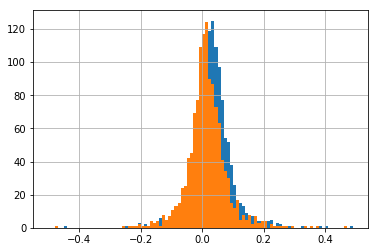

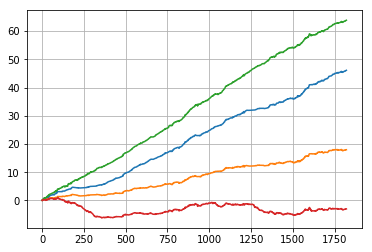

In [39]:
import matplotlib.pyplot as plt

plt.figure(0)
bins = [i/100 for i in range(-50,50)]
histG = plt.hist(positions[pos_under_2p]['GROI'], bins=bins)
histR = plt.hist(positions[pos_under_2p]['ROI'], bins=bins)
plt.grid()

plt.figure(1)
plt.plot(positions[pos_under_2p]['GROI'].cumsum())
plt.plot(positions[pos_under_2p]['ROI'].cumsum())
plt.grid()

#plt.figure(2)
cumG = plt.plot(positions['GROI'].cumsum())#, bins=bins
cumR = plt.plot(positions['ROI'].cumsum())

Di
10    0.0326
11   -0.1293
12   -0.1412
13    0.9300
14    0.4389
15   -0.1572
16    0.8591
17    0.2480
18    0.5097
19    0.3055
20    0.5728
21    0.3495
22    0.4844
23    2.1396
24    0.9034
25    0.5343
26    1.5846
27    0.8791
28    1.1064
31   -0.0023
32    0.3320
33    0.5718
34    0.0259
35   -0.1205
36   -0.6543
37    0.8273
38    0.5717
39    1.0671
40    0.9027
41    0.4429
42    1.2524
43    0.3192
44    0.4898
45    0.5633
Name: ROI, dtype: float64


(array([1., 0., 2., 3., 7., 8., 4., 4., 2., 2.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <a list of 10 Patch objects>)

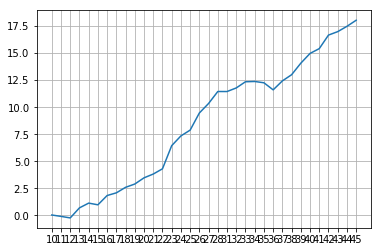

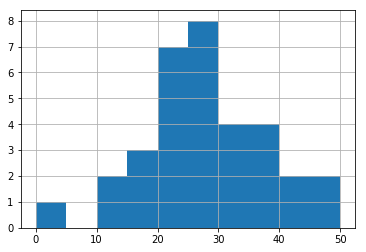

In [49]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = positions[pos_under_2p].groupby([pd.to_datetime(positions[pos_under_2p]['Di']).dt.strftime('%W')])['ROI']
weekly_sum = weekly_group.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
plt.figure(0)
plt.plot(weekly_sum.cumsum())
plt.grid()
print(weekly_sum)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in groupedbyweek:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [212]:
positions[positions['ROI']<-.2]['ROI'].sum()

-5.5287999999999995

In [189]:
positions['GROI'].max()

0.7135